In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def find_files_to_do(aGSC):

    aGSC = 'MetricResults--%s'%aGSC
    specie_tmp = aGSC.split('--')[1].split('__')[1].split('_')[1]
    algo = 'NoScaling__LR_l2_1.0'
    combos = []
    # get file names needed
    # hs emebddings
    networks = ['BioGRID', 'IMP']
    method = ['SVD','Pecanpy']
    dims = ['500','2000','10000']
    SVD_params = ['StdScl','None']
    p_q = [('0.1','0.1'),('0.01','0.1'),('0.001','0.1'),('0.0001','0.1'),('0.1','0.01'),('0.1','0.001'),('0.1','0.0001')]
    for anet in networks:
        for adim in dims:
            if (specie_tmp=='mm') and (adim=='10000') and(anet=='BioGRID'):
                continue
            for ameth in method:
                if ameth == 'SVD':
                    for item in SVD_params:
                        mystring = '%s--%s__%s_raw__eggnog_direct_AllOnes__%s_%s_%s.emb--%s'%(aGSC,specie_tmp,anet,ameth,adim,item,algo)
                        combos.append(mystring)
                elif ameth == 'Pecanpy':
                    for item in p_q:
                        if anet == 'BioGRID':
                            mystring = '%s--%s__%s_raw__eggnog_direct_AllOnes__%s_%s_SparseOTF_%s_%s_120_8_10_weighted_undirected.emb--%s'%(aGSC,specie_tmp,anet,ameth,adim,item[0],item[1],algo)
                        elif anet == 'IMP':
                            mystring = '%s--%s__%s_raw__eggnog_direct_AllOnes__%s_%s_DenseOTF_%s_%s_120_8_10_weighted_undirected.emb--%s'%(aGSC,specie_tmp,anet,ameth,adim,item[0],item[1],algo)
                        combos.append(mystring)
    # hs_mm embeddings
    networks = ['BioGRID', 'IMP']
    weights = ['AllOnes','AllFives','SummedDegree-0.50','SummedDegree-1.0']
    method = ['SVD','Pecanpy']
    dims = ['500','2000','10000']
    SVD_params = ['StdScl','None']
    p_q = [('0.1','0.1'),('0.01','0.1'),('0.001','0.1'),('0.0001','0.1'),('0.1','0.01'),('0.1','0.001'),('0.1','0.0001')]
    for anet in networks:
        for aw in weights:
            if aw in ['AllOnes','AllFives']:
                edges = 'undirected'
            elif aw in ['SummedDegree-0.50','SummedDegree-1.0']:
                edges = 'directed'
            for adim in dims:
                for ameth in method:
                    if ameth == 'SVD':
                        for item in SVD_params:
                            mystring = '%s--hs_mm__%s_raw__eggnog_direct_%s__%s_%s_%s.emb--%s'%(aGSC,anet,aw,ameth,adim,item,algo)
                            combos.append(mystring)
                    elif ameth == 'Pecanpy':
                        for item in p_q:
                            if anet == 'BioGRID':
                                mystring = '%s--hs_mm__%s_raw__eggnog_direct_%s__%s_%s_SparseOTF_%s_%s_120_8_10_weighted_%s.emb--%s'%(aGSC,anet,aw,ameth,adim,item[0],item[1],edges,algo)
                            elif anet == 'IMP':
                                mystring = '%s--hs_mm__%s_raw__eggnog_direct_%s__%s_%s_DenseOTF_%s_%s_120_8_10_weighted_%s.emb--%s'%(aGSC,anet,aw,ameth,adim,item[0],item[1],edges,algo)
                            combos.append(mystring)
    # adj mat inf single species
    networks = ['BioGRID', 'IMP']
    for anet in networks:
        mystring = '%s--%s__%s_raw__eggnog_direct_AllOnes.adj--%s'%(aGSC,specie_tmp,anet,algo)
        combos.append(mystring)
        mystring = '%s--%s__%s_inf-0.8__eggnog_direct_AllOnes.adj--%s'%(aGSC,specie_tmp,anet,algo)
        combos.append(mystring)
        mystring = '%s--%s__%s_inf-0.8-trans__eggnog_direct_AllOnes.adj--%s'%(aGSC,specie_tmp,anet,algo)
        combos.append(mystring)
    # adj mat and inf human and mouse
    networks = ['BioGRID', 'IMP']
    weights = ['AllOnes','AllFives','SummedDegree-0.50','SummedDegree-1.0']
    for anet in networks:
        for aw in weights:
            mystring = '%s--hs_mm__%s_raw__eggnog_direct_%s.adj--%s'%(aGSC,anet,aw,algo)
            combos.append(mystring)
            # do for both regular and trans
            mystring = '%s--hs_mm__%s_inf-0.8__eggnog_direct_%s.adj--%s'%(aGSC,anet,aw,algo)
            combos.append(mystring)
            mystring = '%s--hs_mm__%s_inf-0.8-trans__eggnog_direct_%s.adj--%s'%(aGSC,anet,aw,algo)
            combos.append(mystring)
    print('The total of number of combos to try is',len(combos))
    # print(combos[0:10])
    return combos, specie_tmp

def read_in_files(combos):
    fp_results = '../results/metrics/'
    all_FNs = glob.glob(fp_results +'MetricResults*.tsv')
    all_FNs = [item.strip().split('/')[-1].split('.t')[0] for item in all_FNs]
    df_final = pd.DataFrame()
    for aFN in combos:
        if aFN not in all_FNs:
            print('This file is not in the results',aFN)
            continue
        results_aFN = []
        with open(fp_results+aFN+'.tsv', 'r') as f:
            for idx,line in enumerate(f):
                line = line.strip().split('\t')
                inds = [0,1,2,4,3,5,13,14]
                if idx == 0:
                    col_names = [line[item] for item in inds]
                    col_names.pop(4)
                    col_names.insert(4,'dim_size')
                    col_names.insert(5,'emb_params')
                    col_names.insert(6,'net_con_data')
                    col_names.insert(7,'net_con_weight')
                else:
                    good_vals = []
                    for aind in inds:
                        if aind == 4:
                            if line[aind] == 'adj':
                                if 'trans' in line[1]:
                                    good_vals.append(line[2]+'-'+line[aind]+'-'+'-'.join(line[1].split('_')[1].split('-')[0:2]))
                                    good_vals.append('max')
                                    good_vals.append('Trans')
                                else:
                                    good_vals.append(line[2]+'-'+line[aind]+'-'+line[1].split('_')[1])
                                    good_vals.append('max')
                                    good_vals.append('NoVals')
                            else:
                                good_vals.append(line[2]+'-'+line[aind].split('_')[0]+'-'+line[1].split('_')[1])
                                good_vals.append(line[aind].split('_')[1])
                                if 'SVD' in line[aind]:
                                    good_vals.append(line[aind].split('_')[2])
                                elif 'Pecanpy' in line[aind]:
                                    good_vals.append('_'.join(line[aind].split('_')[2:8]))
                        elif aind == 3:
                            net_con_vals = line[aind].split('_')
                            good_vals.append(net_con_vals[0]+'-'+net_con_vals[1])
                            good_vals.append(net_con_vals[2])
                        elif (aind == 13) or (aind == 14):
                            good_vals.append(float(line[aind]))
                        elif aind == 1:
                            good_vals.append(line[aind].split('_')[0])
                        elif aind == 5:
                            good_vals.append(line[aind].split('__')[0])
                        else:
                            good_vals.append(line[aind])
                    results_aFN.append(good_vals)
        df_aFN = pd.DataFrame(results_aFN,columns=col_names)
        df_final = pd.concat([df_final,df_aFN])
    print('The shape of df_final is', df_final.shape)
    # df_final[df_final['feature_type']=='hs-adj-inf-0.8']
    return df_final

# Get df_final for the method

In [3]:
combos, specie_tmp = find_files_to_do('MethodNum-0__Monarch_hs_20_100_0.5_0.5')
df_final = read_in_files(combos)

The total of number of combos to try is 300
The shape of df_final is (55200, 11)


# Make plots for hs_mm_pecanpy

In [4]:
def plot_hs_mm_pecanpy(df,myvar1,myvar2,myvar3):

    df_tmp = df_final[df_final['feature_type']=='hs_mm-Pecanpy-raw']
    params_tmp = df_tmp['emb_params'].tolist()
    new_params = []
    for item in params_tmp:
        new_params.append('_'.join(item.split('_')[1:3]))
    df_tmp['emb_params'] = new_params
    df_tmp.head()
    for anet in ['BioGRID','IMP']:
        for avar1 in df_tmp[myvar1].unique():
            df_tmp2 = df_tmp[(df_tmp['network']==anet)&(df_tmp[myvar1]==avar1)]
            fig,ax = plt.subplots(figsize=(8,8))
            sns.boxplot(data=df_tmp2,x=myvar2,y='log2p',hue=myvar3,
                        notch=True,showfliers=False)
            plt.legend(loc=1)
            ax.set_title(anet + ' and ' + avar1)

/var/folders/44/q19dxly12jd6rqltv_kdf3q00000gq/T/ipykernel_44779/3284637097.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['emb_params'] = new_params


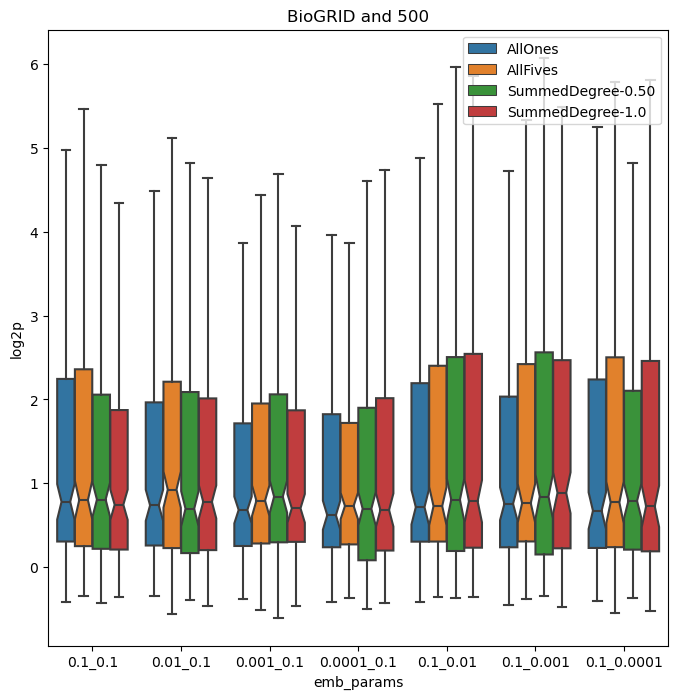

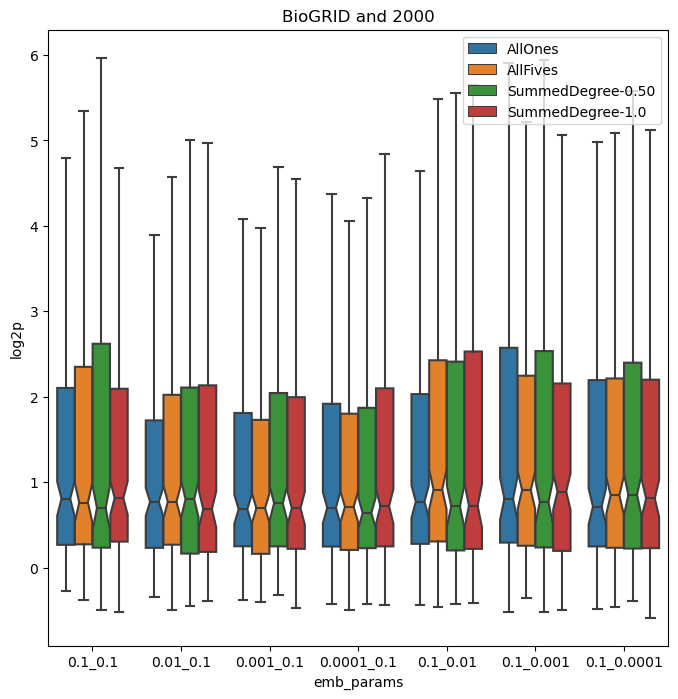

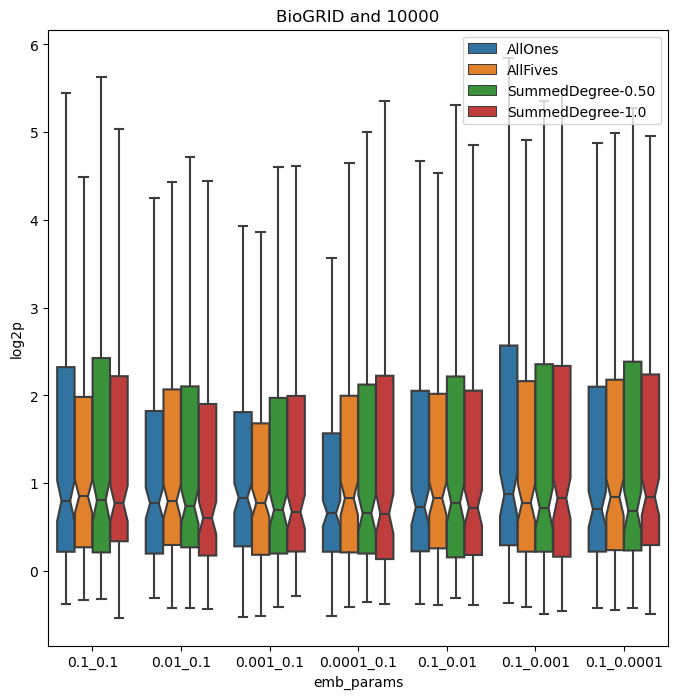

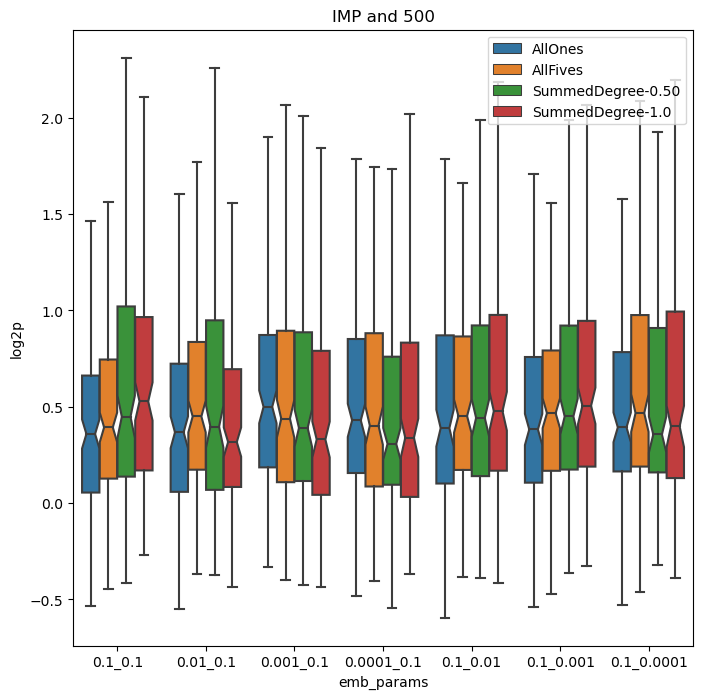

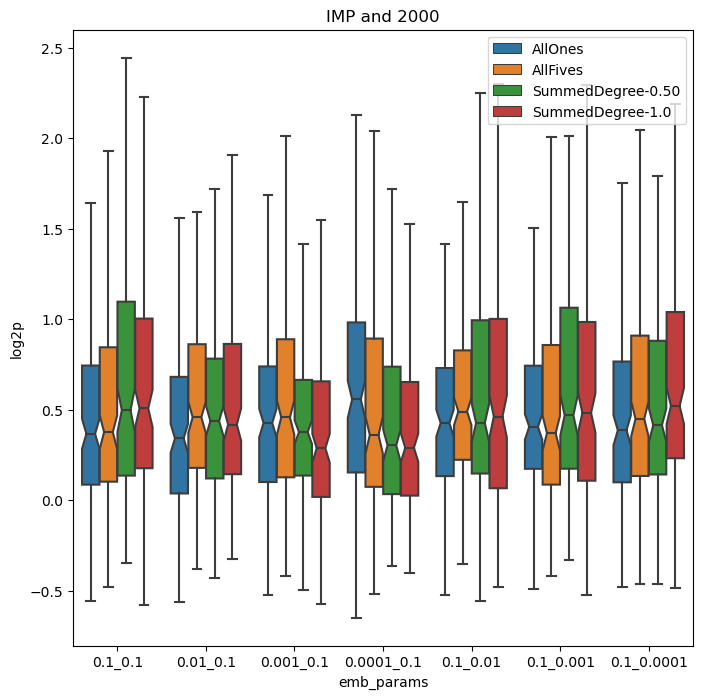

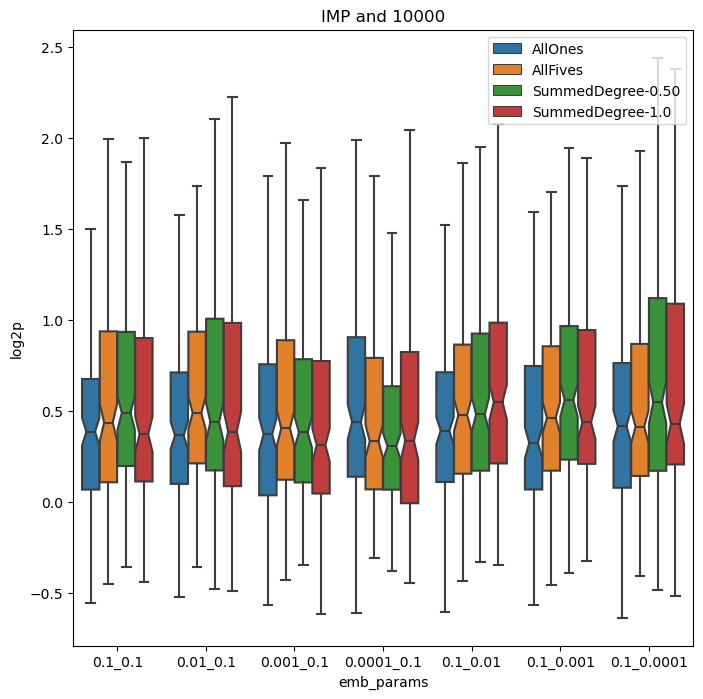

In [5]:
plot_hs_mm_pecanpy(df_final,'dim_size','emb_params','net_con_weight')

/var/folders/44/q19dxly12jd6rqltv_kdf3q00000gq/T/ipykernel_44779/3284637097.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['emb_params'] = new_params


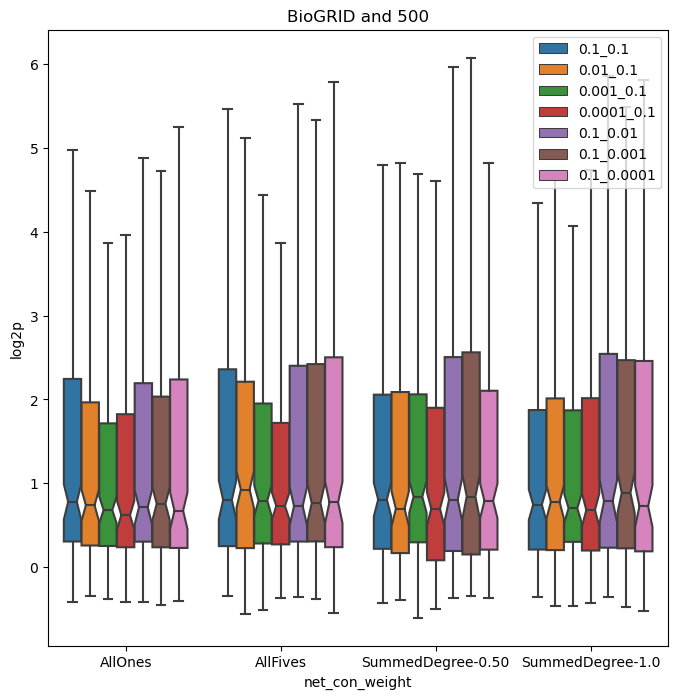

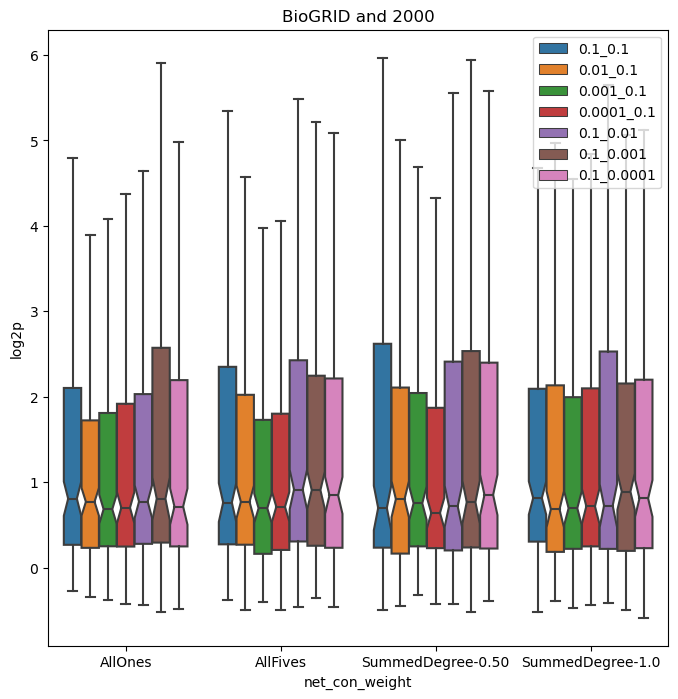

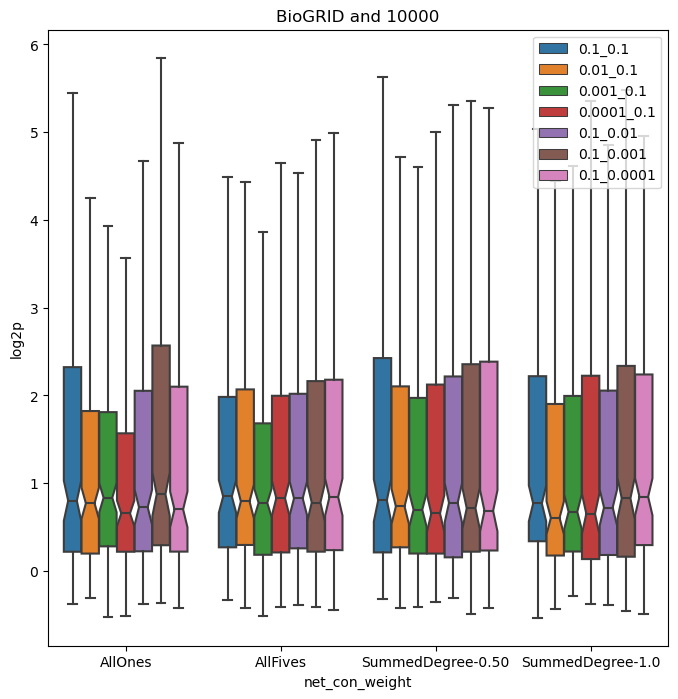

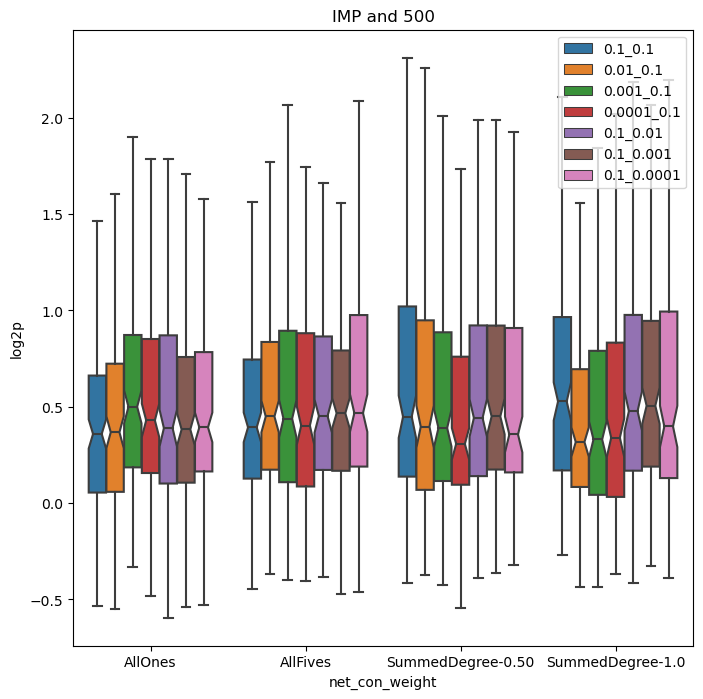

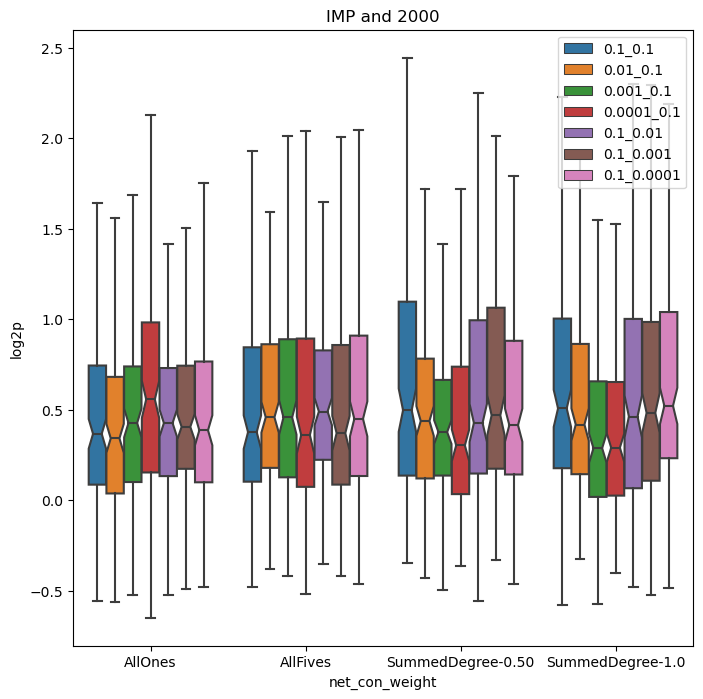

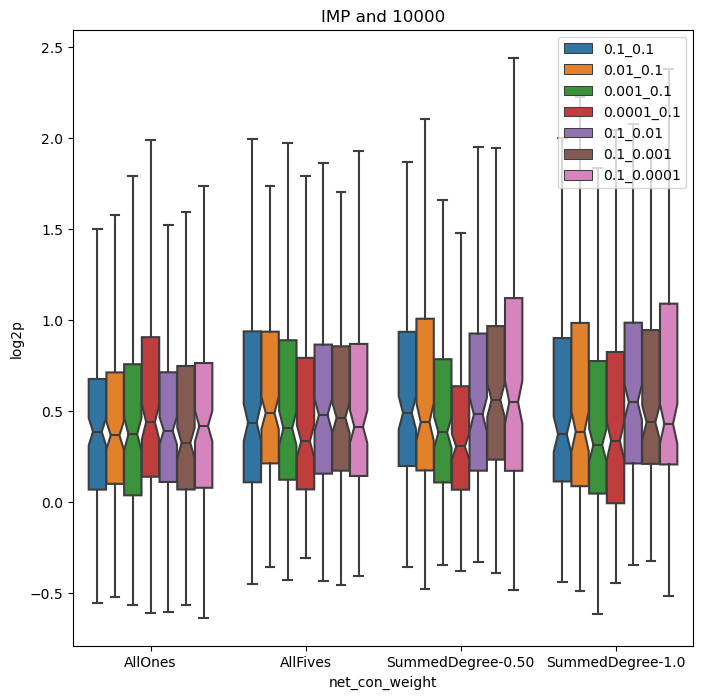

In [6]:
plot_hs_mm_pecanpy(df_final,'dim_size','net_con_weight','emb_params')

/var/folders/44/q19dxly12jd6rqltv_kdf3q00000gq/T/ipykernel_44779/3284637097.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['emb_params'] = new_params


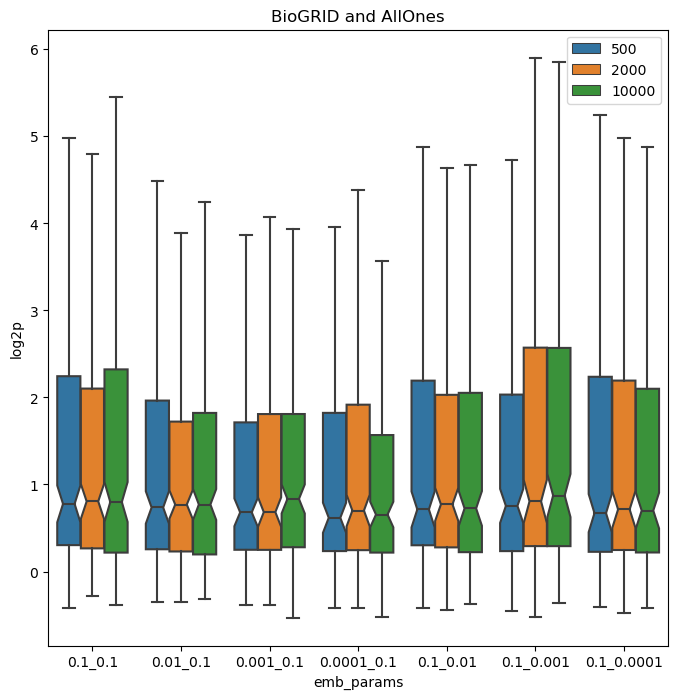

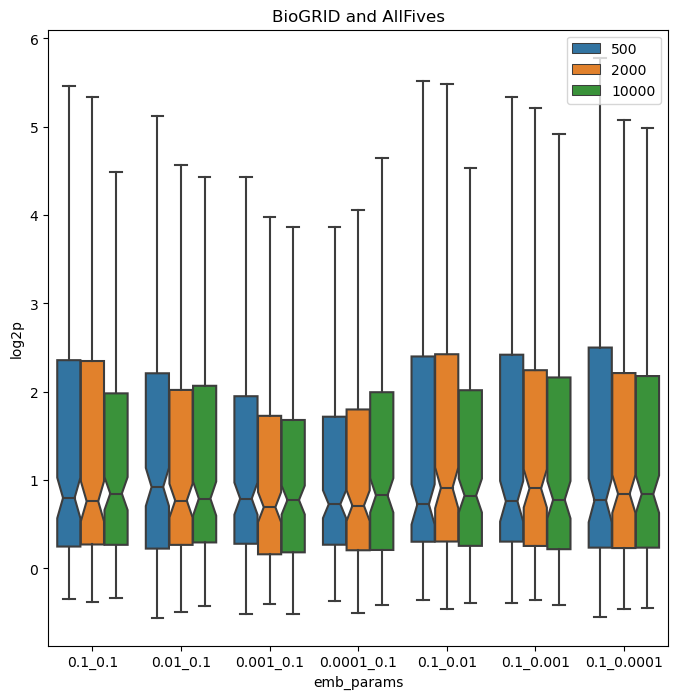

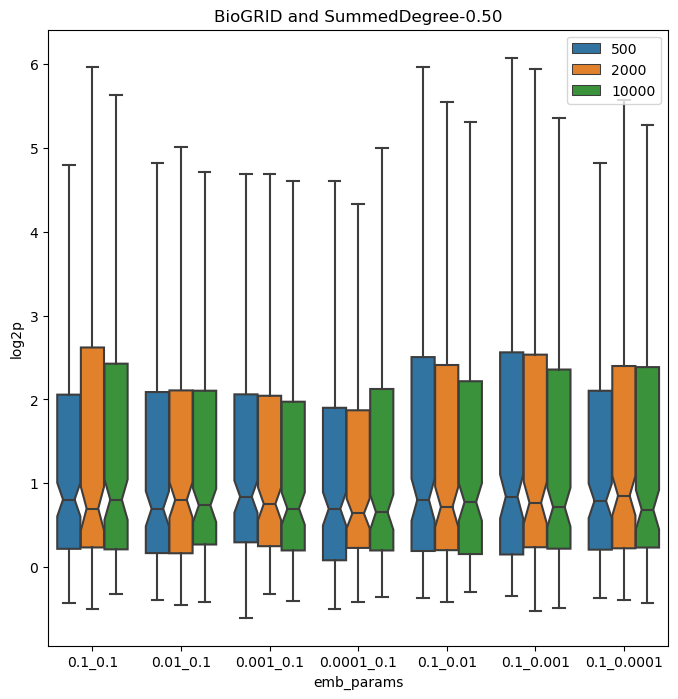

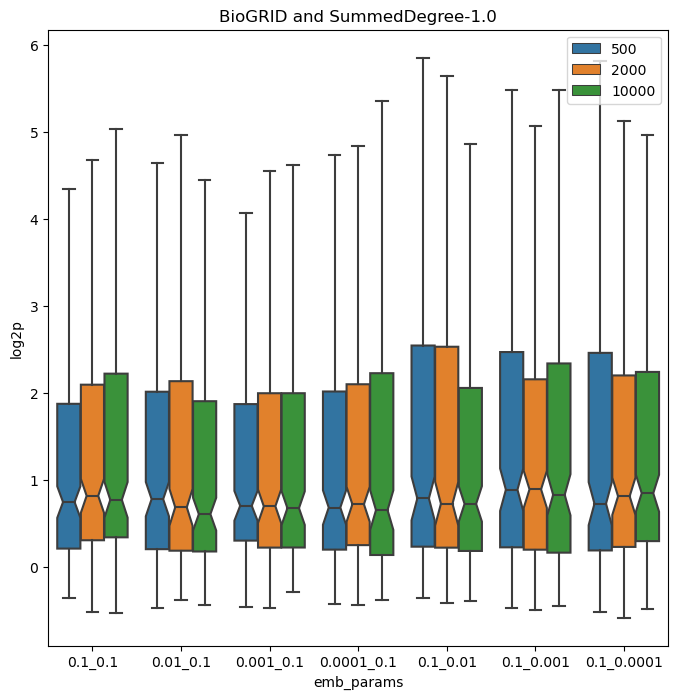

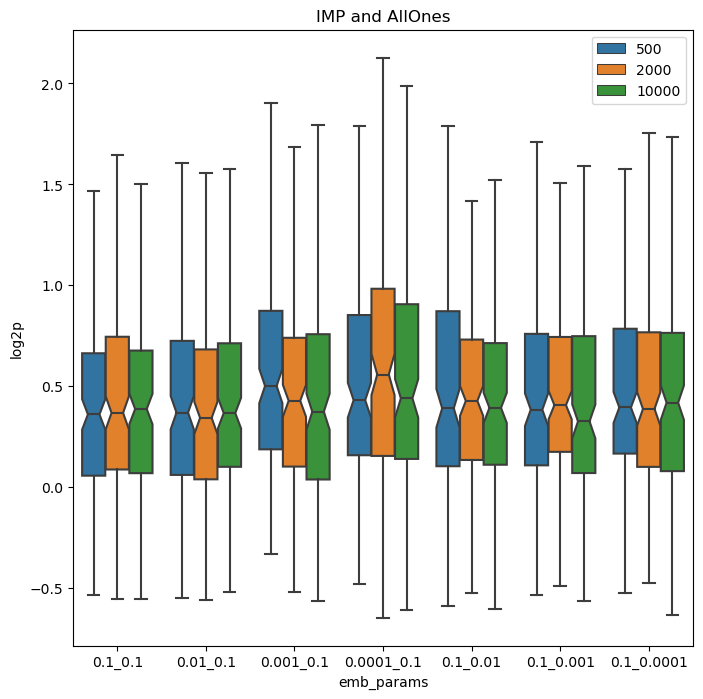

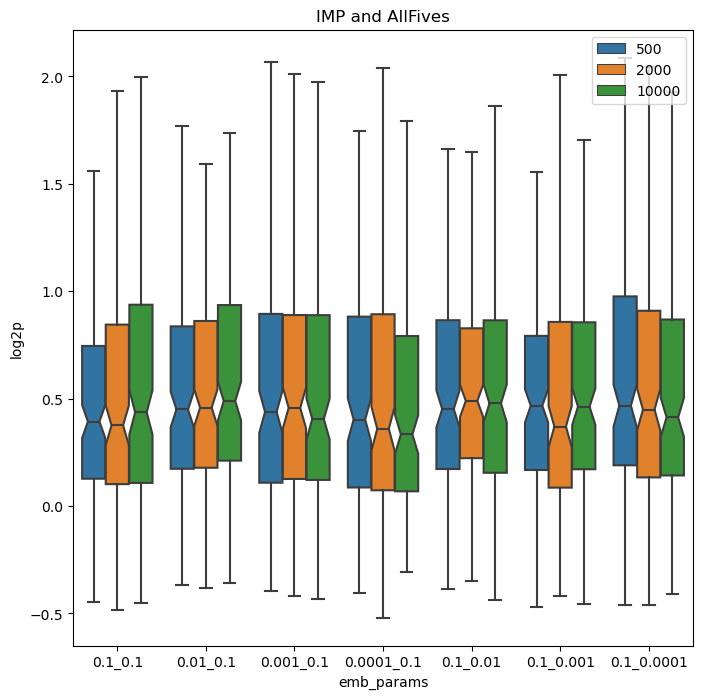

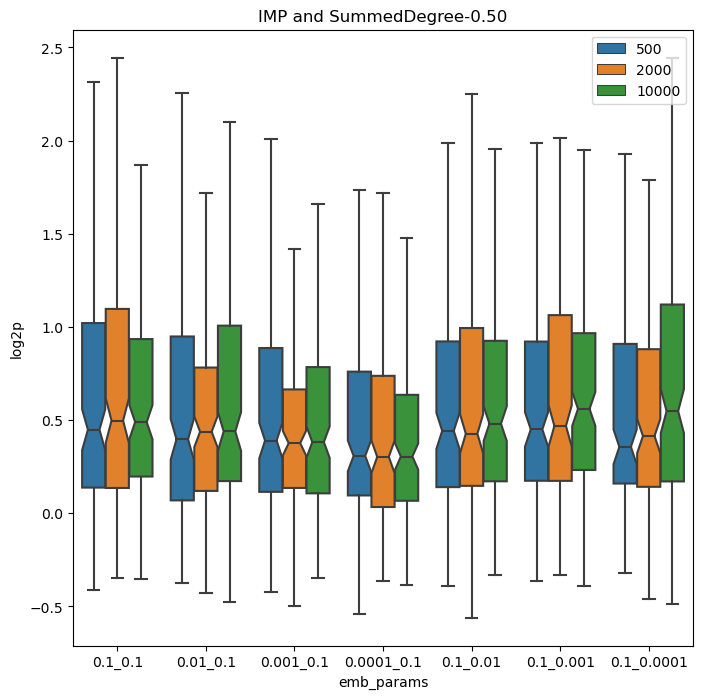

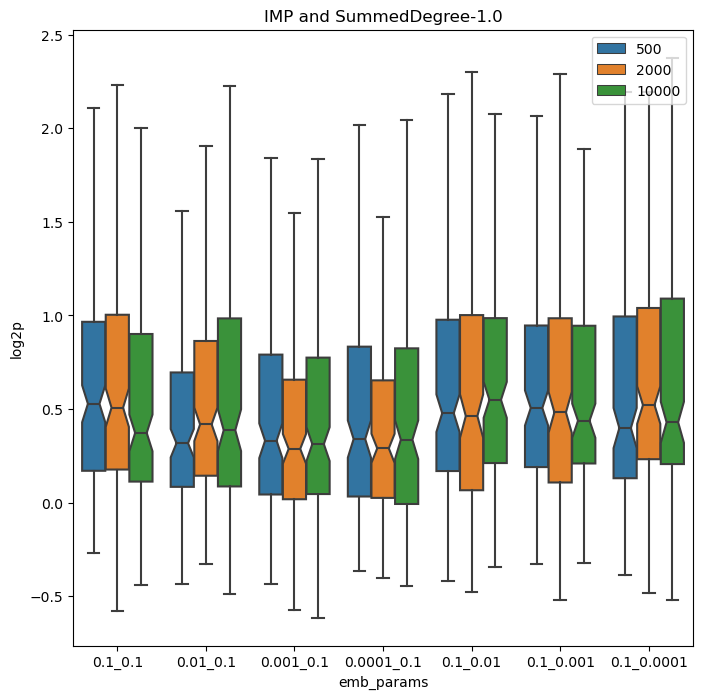

In [7]:
plot_hs_mm_pecanpy(df_final,'net_con_weight','emb_params','dim_size')

/var/folders/44/q19dxly12jd6rqltv_kdf3q00000gq/T/ipykernel_44779/3284637097.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['emb_params'] = new_params


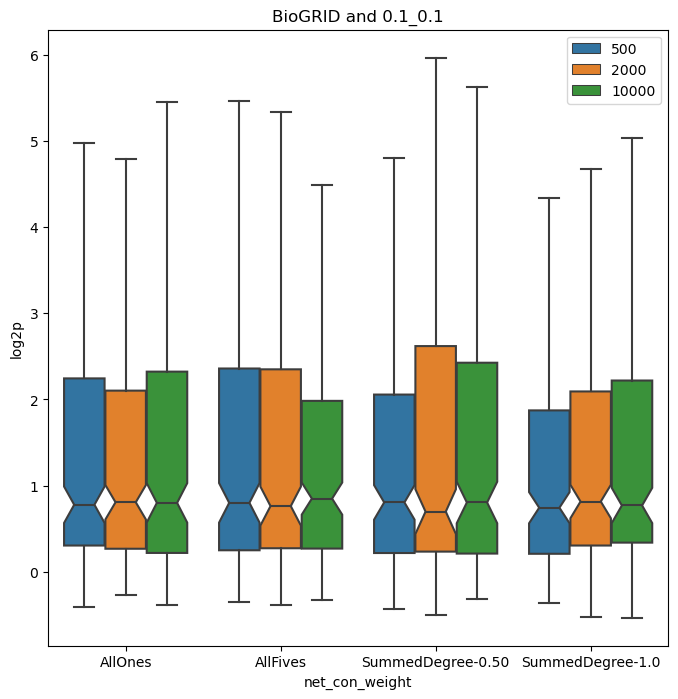

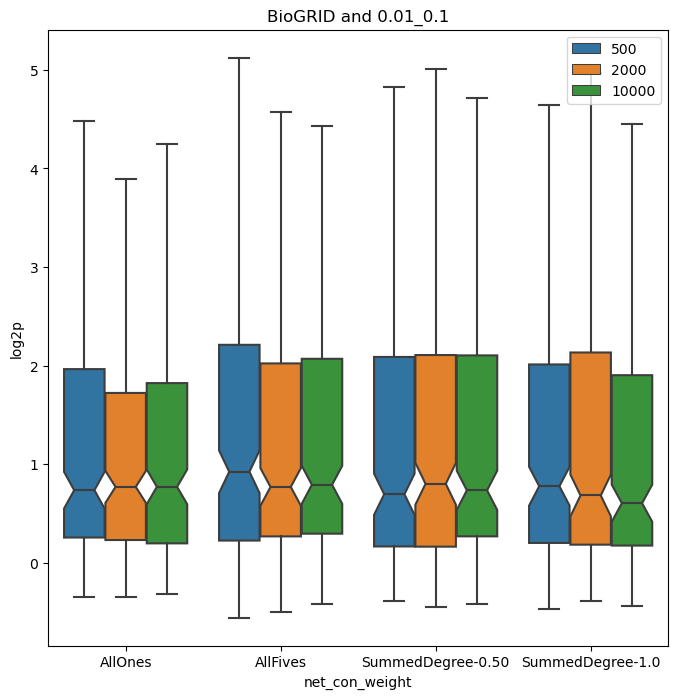

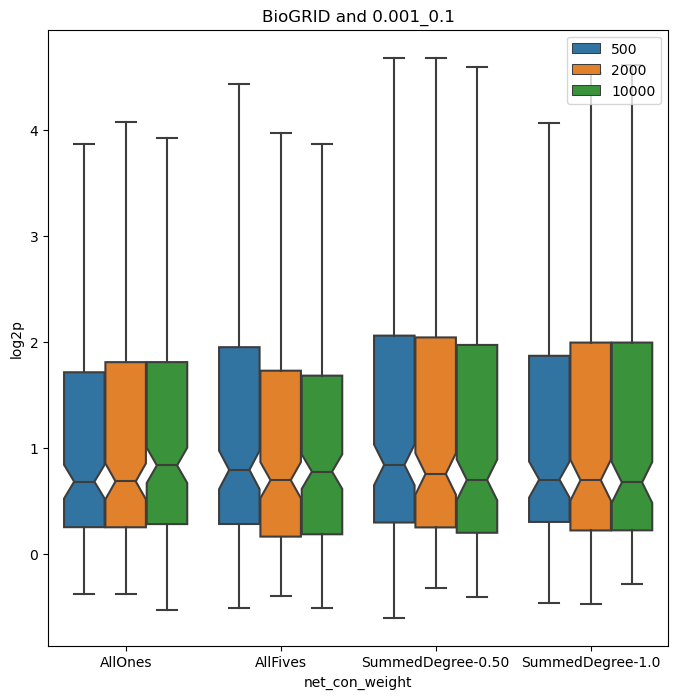

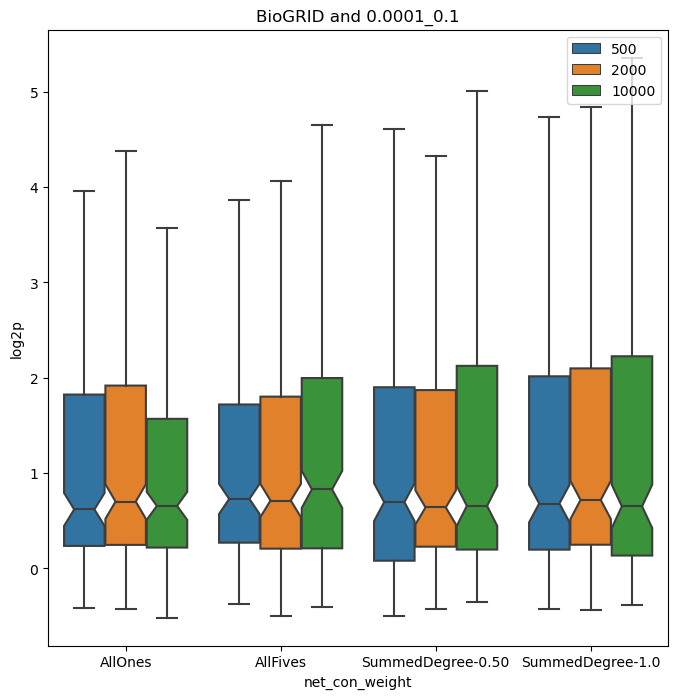

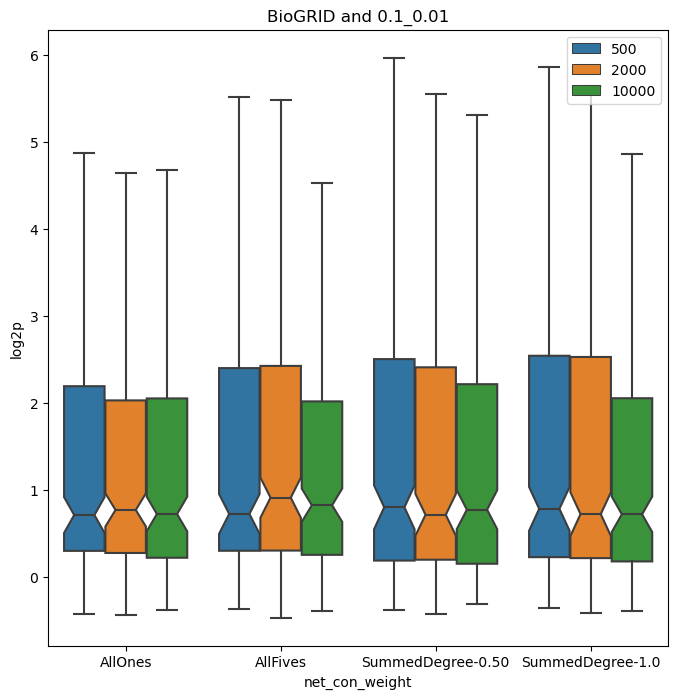

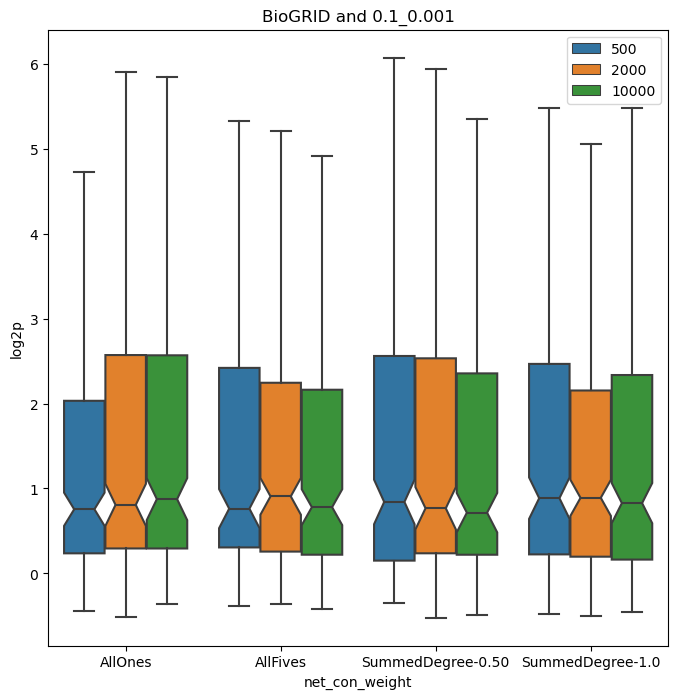

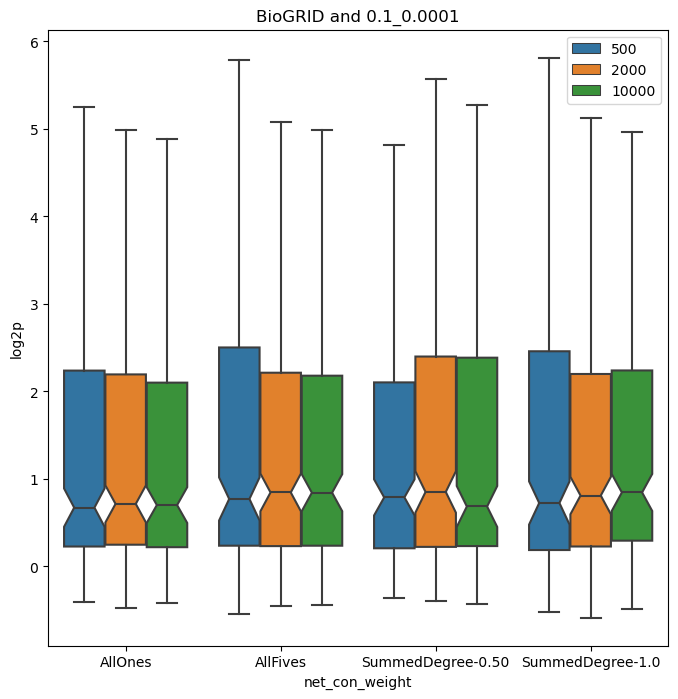

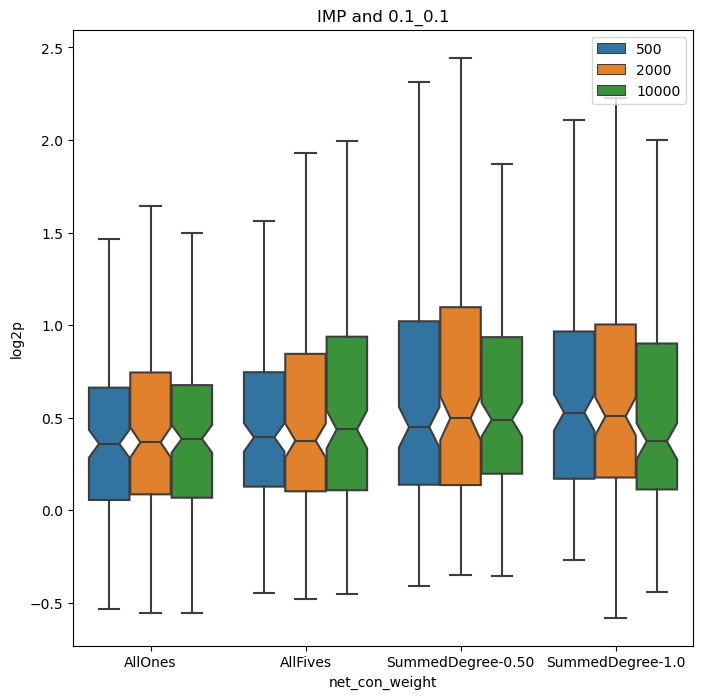

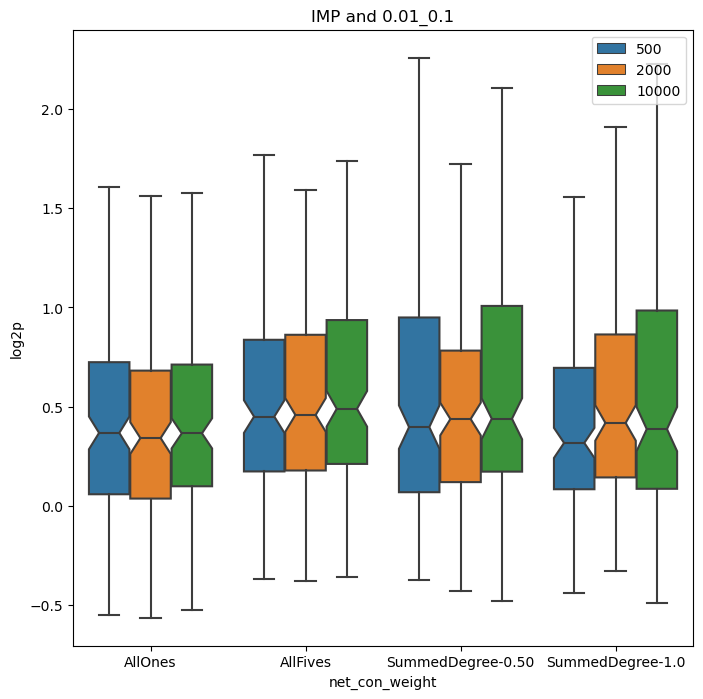

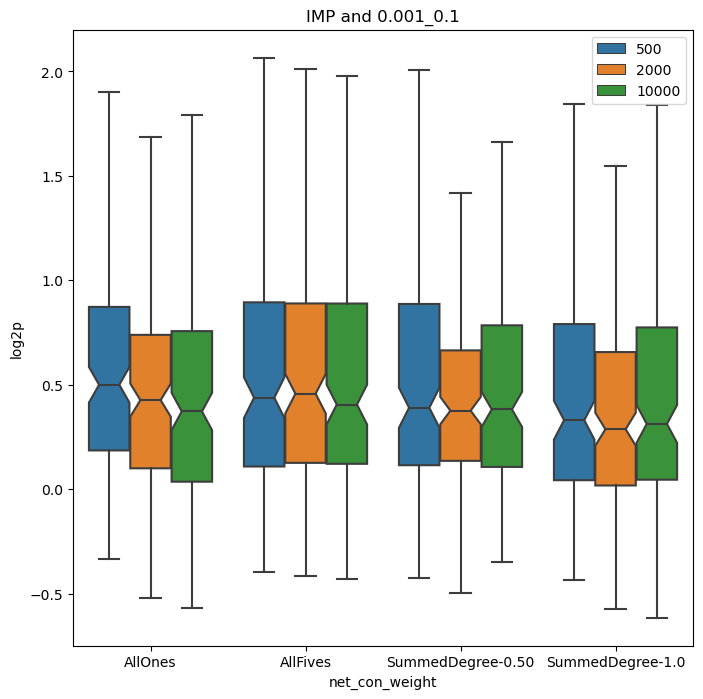

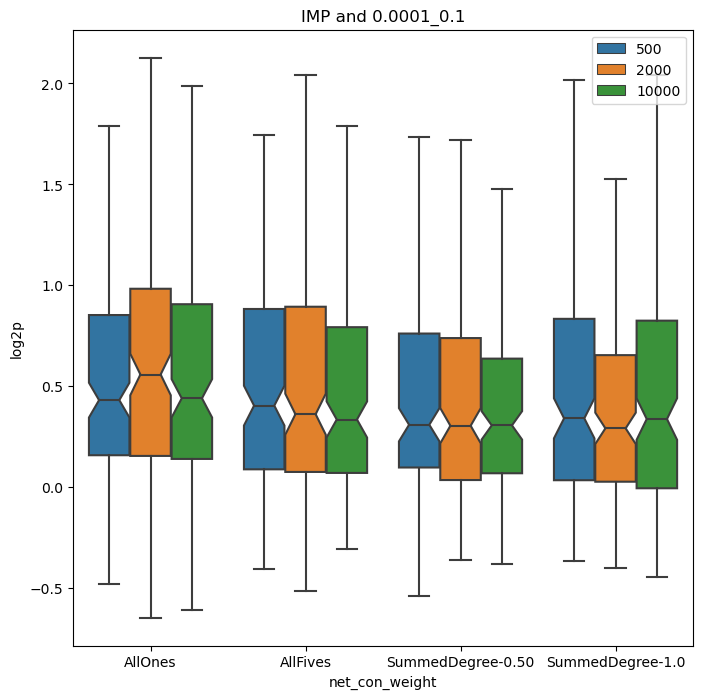

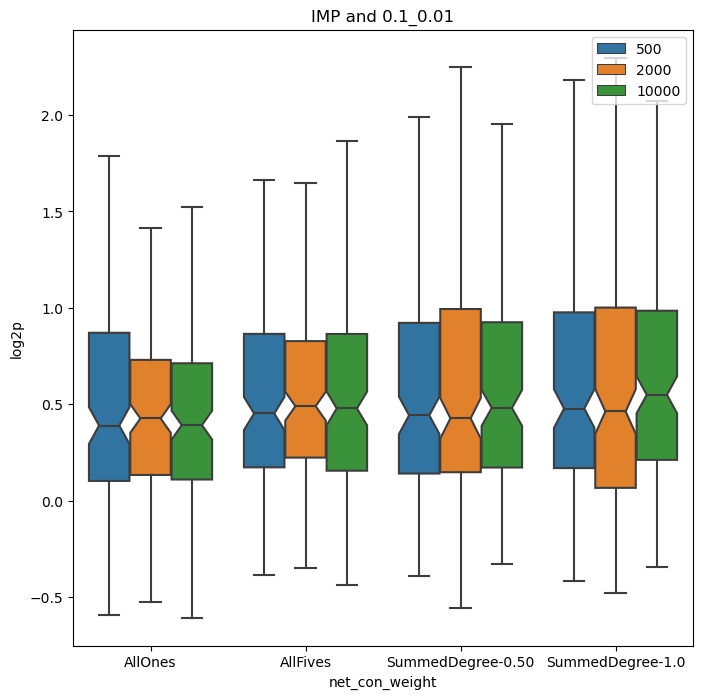

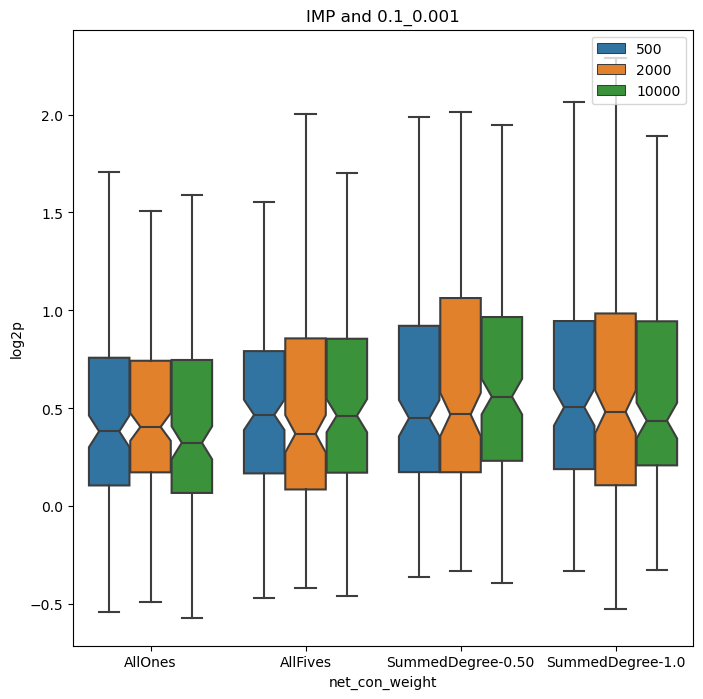

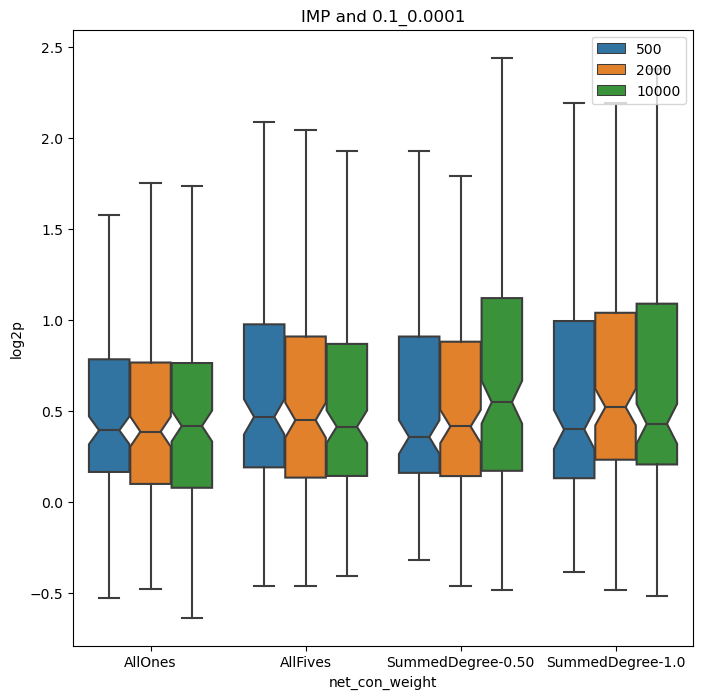

In [8]:
plot_hs_mm_pecanpy(df_final,'emb_params','net_con_weight','dim_size')

# Plots for hs(or mm)_pecanpy

/var/folders/44/q19dxly12jd6rqltv_kdf3q00000gq/T/ipykernel_44779/2154756451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['emb_params'] = new_params


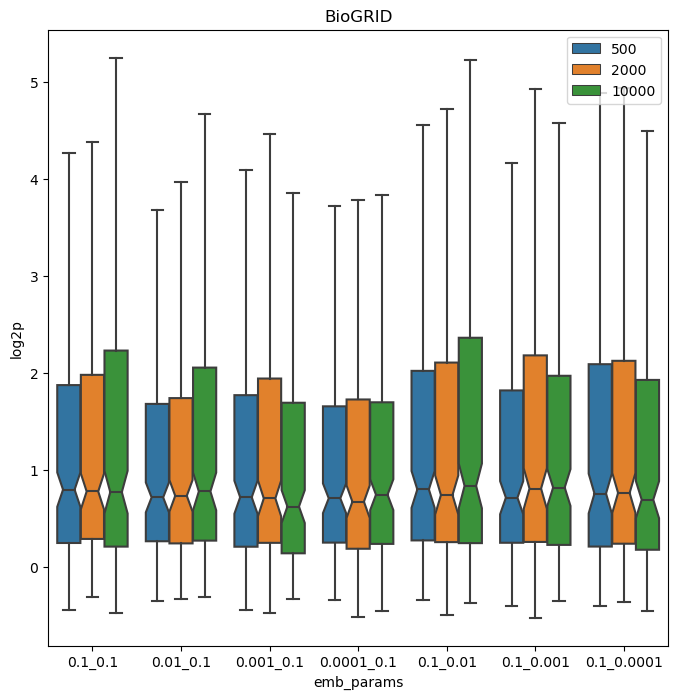

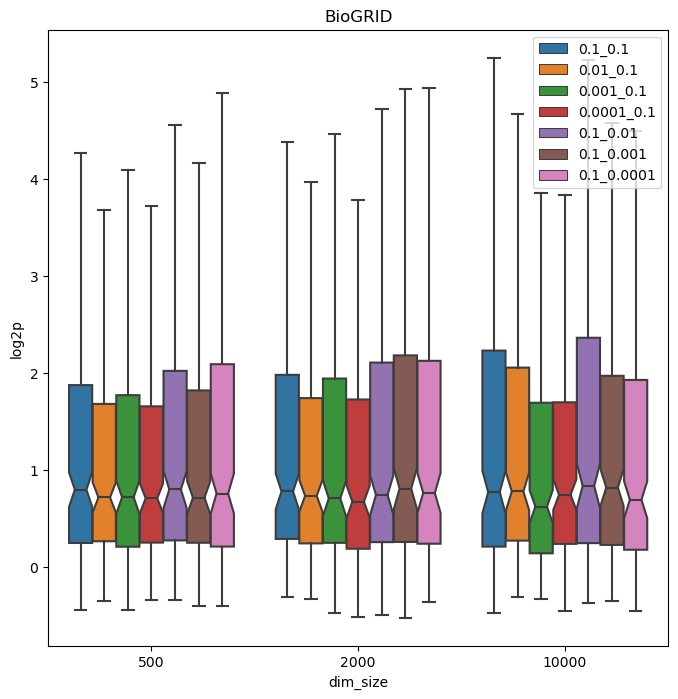

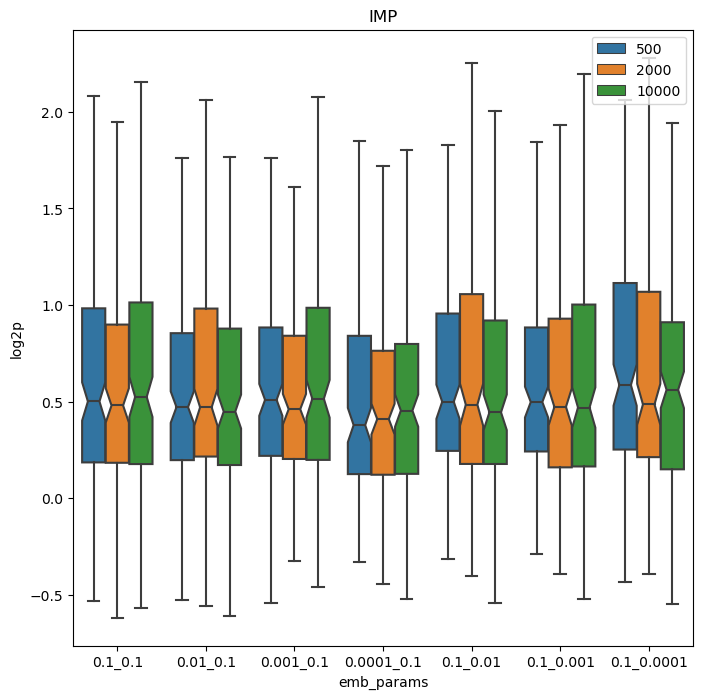

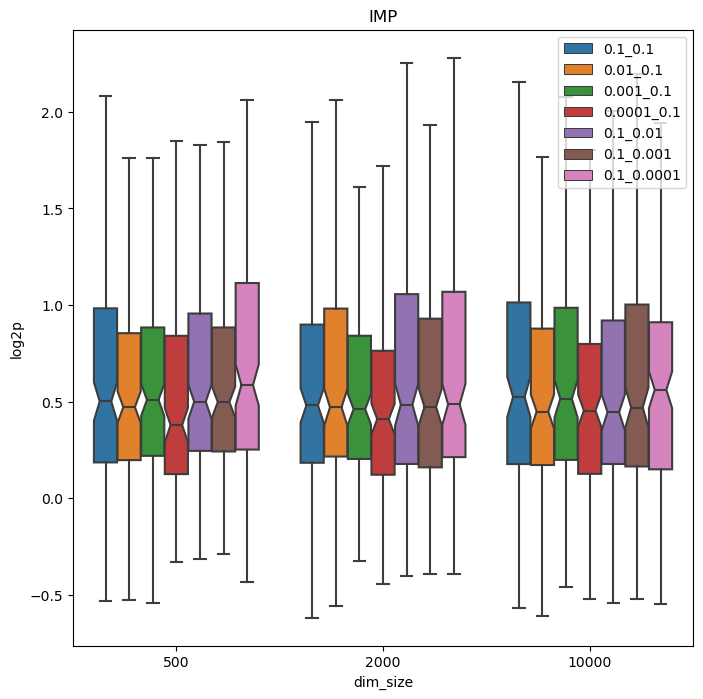

In [9]:
df_tmp = df_final[df_final['feature_type']=='%s-Pecanpy-raw'%specie_tmp]
params_tmp = df_tmp['emb_params'].tolist()
new_params = []
for item in params_tmp:
    new_params.append('_'.join(item.split('_')[1:3]))
df_tmp['emb_params'] = new_params
df_tmp.head()
for anet in ['BioGRID','IMP']:
        df_tmp2 = df_tmp[df_tmp['network']==anet]
        fig,ax = plt.subplots(figsize=(8,8))
        sns.boxplot(data=df_tmp2,x='emb_params',y='log2p',hue='dim_size',
                    notch=True,showfliers=False)
        plt.legend(loc=1)
        ax.set_title(anet)
        fig,ax = plt.subplots(figsize=(8,8))
        sns.boxplot(data=df_tmp2,x='dim_size',y='log2p',hue='emb_params',
                    notch=True,showfliers=False)
        plt.legend(loc=1)
        ax.set_title(anet)

# Plots for hs_mm-adj-inf-0.8

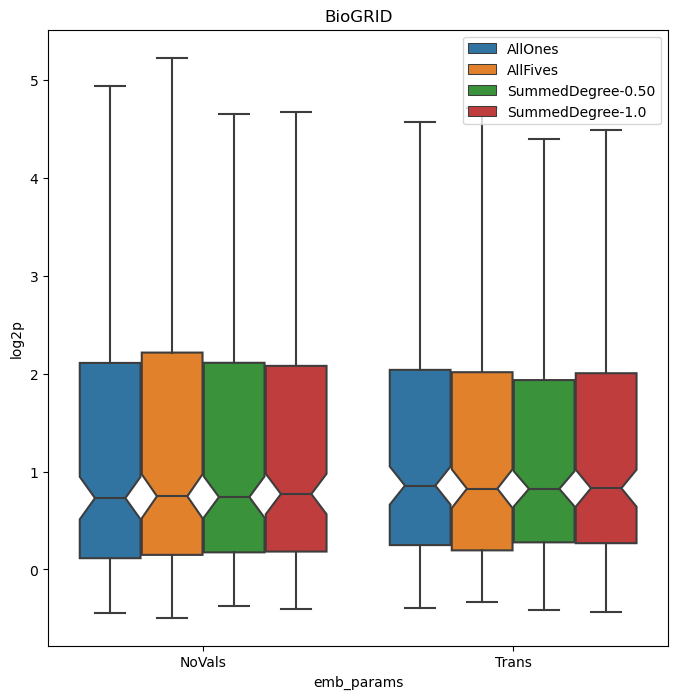

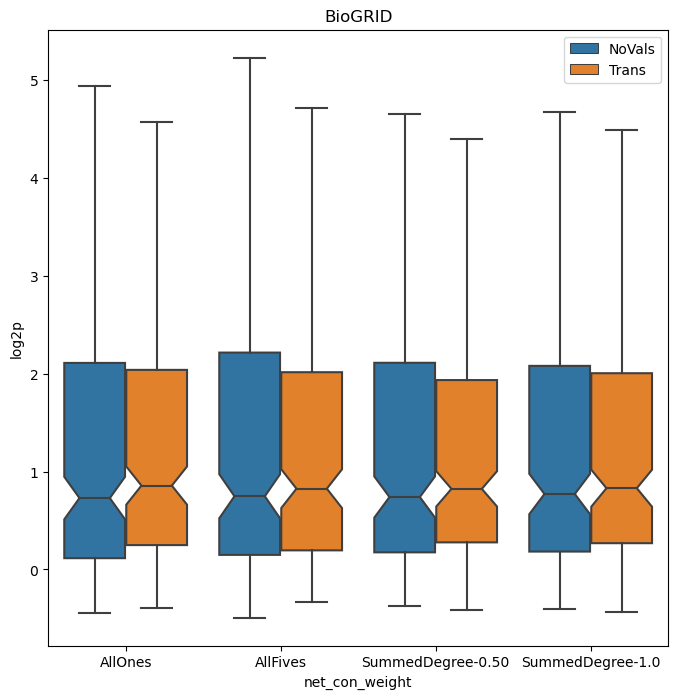

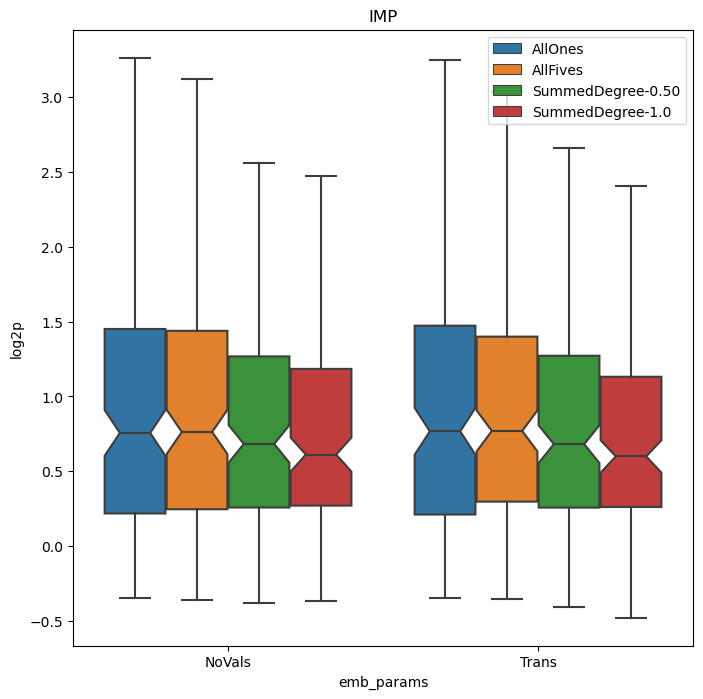

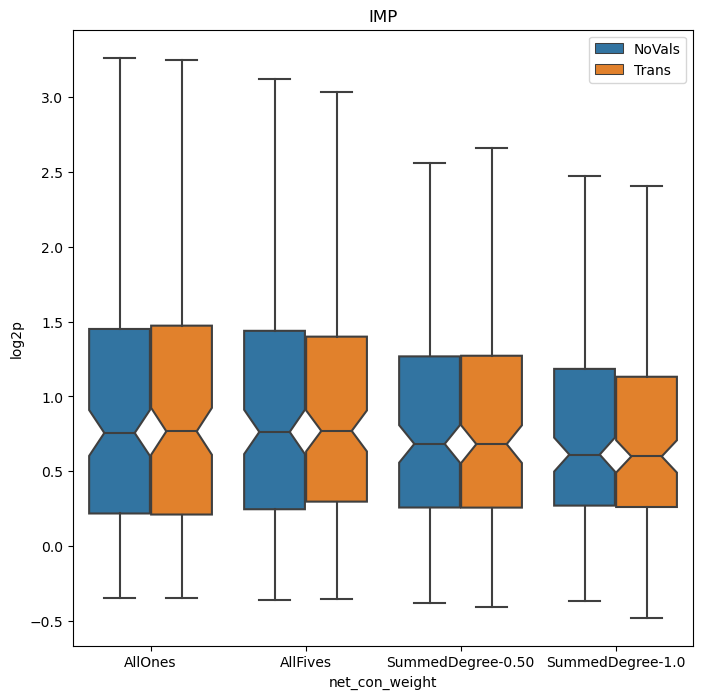

In [10]:
df_tmp = df_final[df_final['feature_type']=='hs_mm-adj-inf-0.8']
for anet in ['BioGRID','IMP']:
    df_tmp2 = df_tmp[df_tmp['network']==anet]
    fig,ax = plt.subplots(figsize=(8,8))
    sns.boxplot(data=df_tmp2,x='emb_params',y='log2p',hue='net_con_weight',
                notch=True,showfliers=False)
    plt.legend(loc=1)
    ax.set_title(anet)
    fig,ax = plt.subplots(figsize=(8,8))
    sns.boxplot(data=df_tmp2,x='net_con_weight',y='log2p',hue='emb_params',
                notch=True,showfliers=False)
    plt.legend(loc=1)
    ax.set_title(anet)

# Plts for hs_mm_SVD-raw

In [11]:
def plot_hs_mm_SVD(df,myvar1,myvar2,myvar3):

    df_tmp = df_final[df_final['feature_type']=='hs_mm-SVD-raw']
    for anet in ['BioGRID','IMP']:
        for avar1 in df_tmp[myvar1].unique():
            df_tmp2 = df_tmp[(df_tmp['network']==anet)&(df_tmp[myvar1]==avar1)]
            fig,ax = plt.subplots(figsize=(8,8))
            sns.boxplot(data=df_tmp2,x=myvar2,y='log2p',hue=myvar3,
                        notch=True,showfliers=False)
            plt.legend(loc=1)
            ax.set_title(anet + ' and ' + avar1)

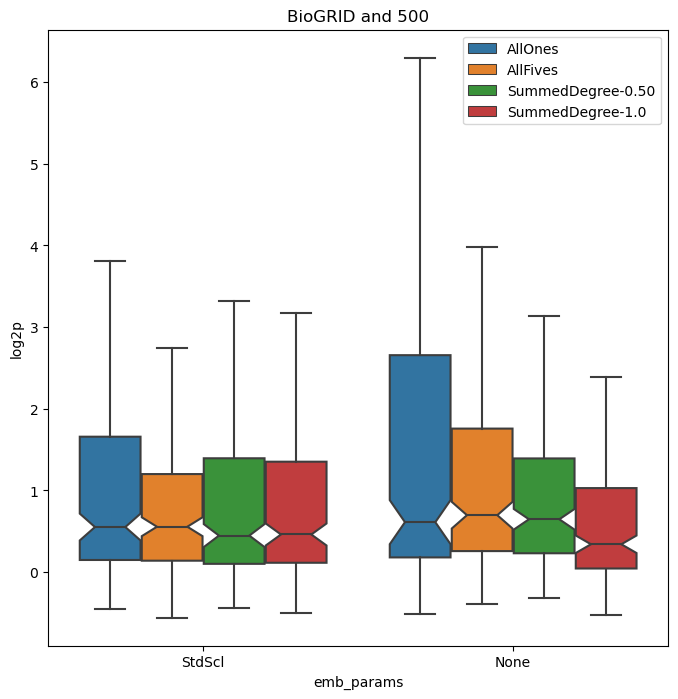

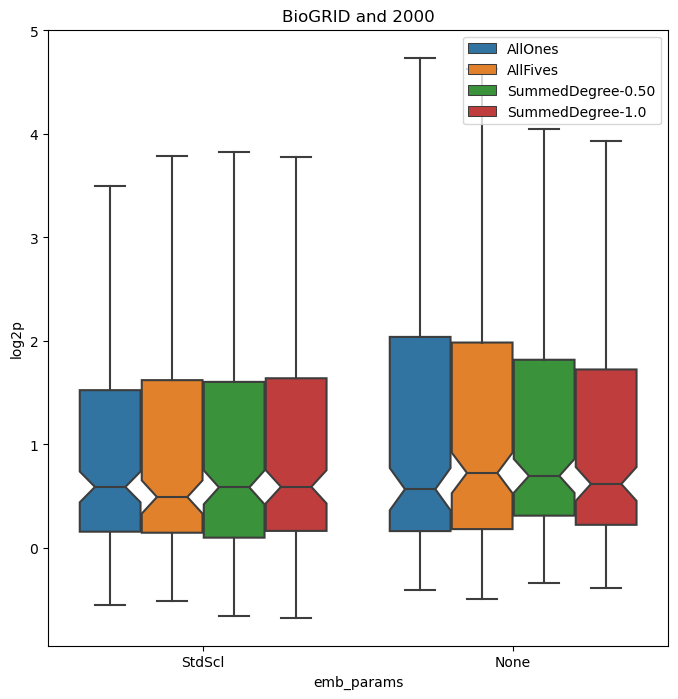

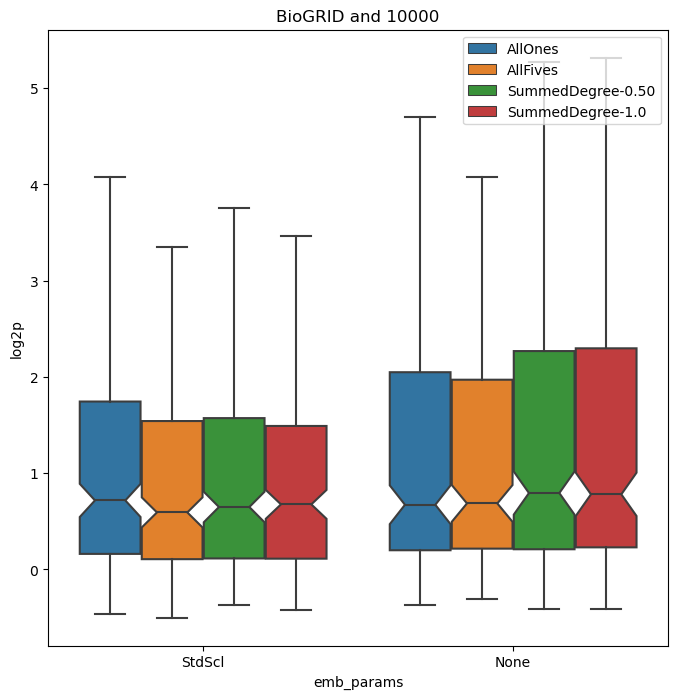

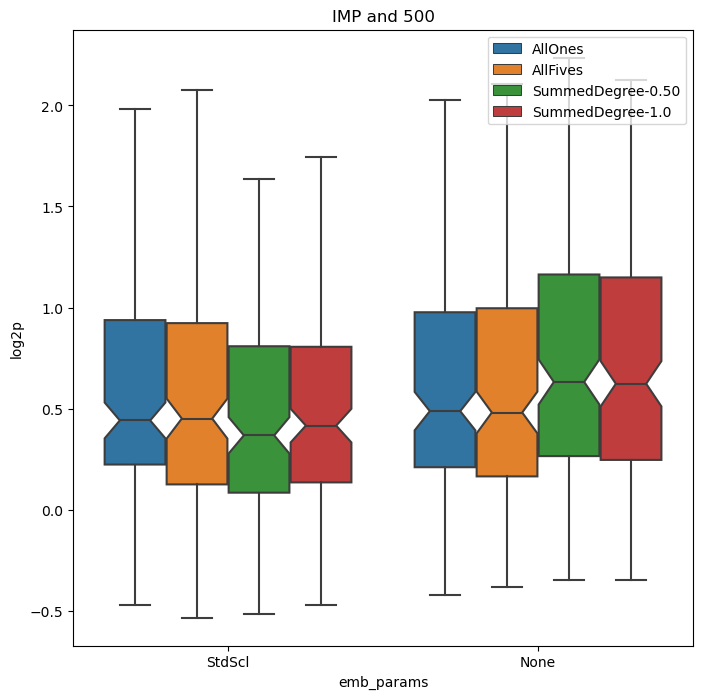

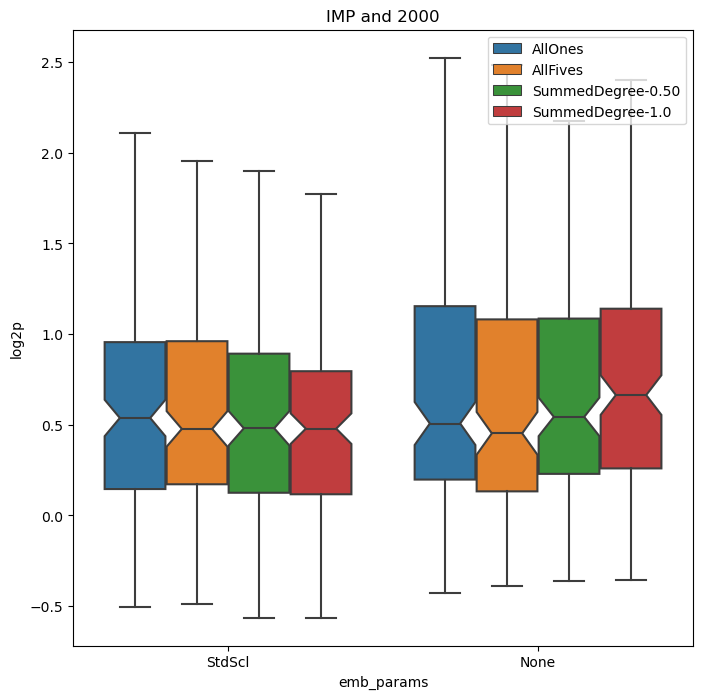

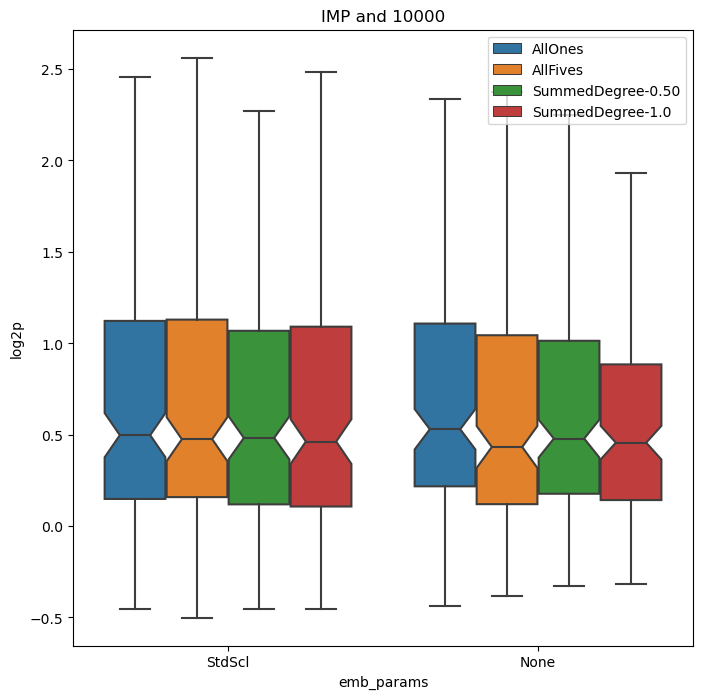

In [12]:
plot_hs_mm_SVD(df_final,'dim_size','emb_params','net_con_weight')

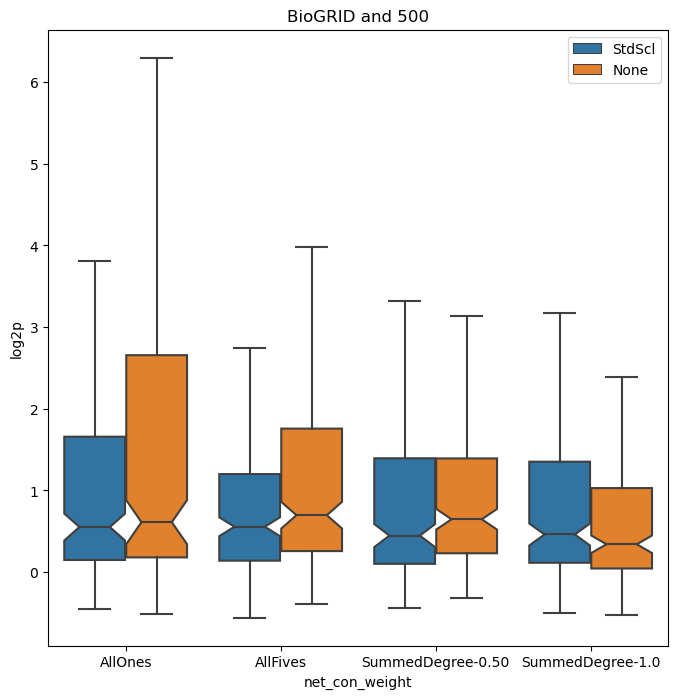

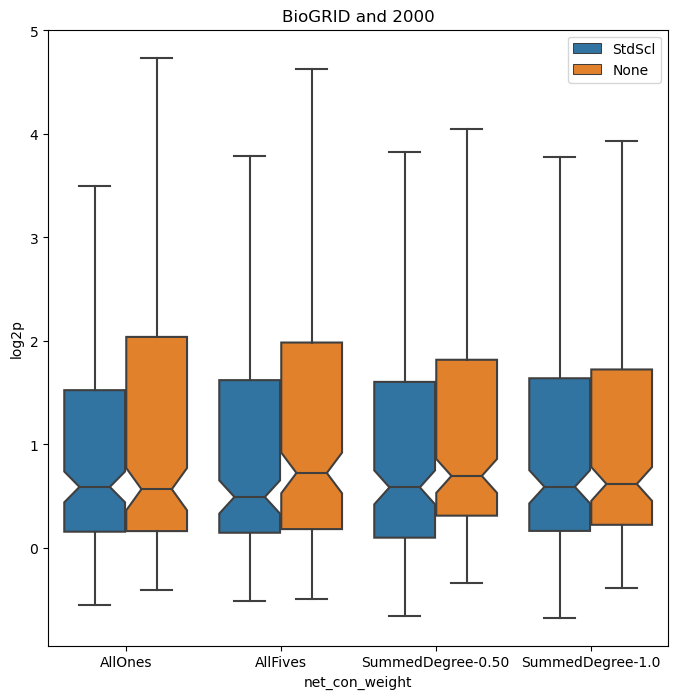

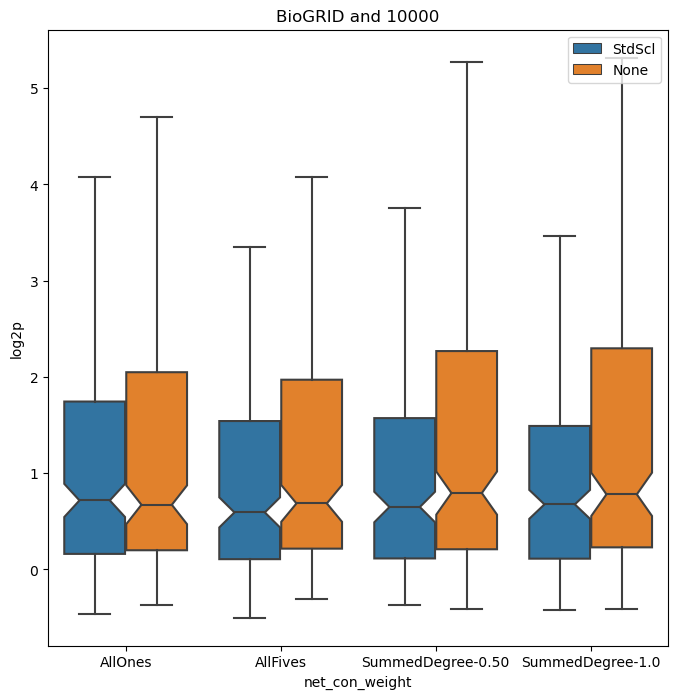

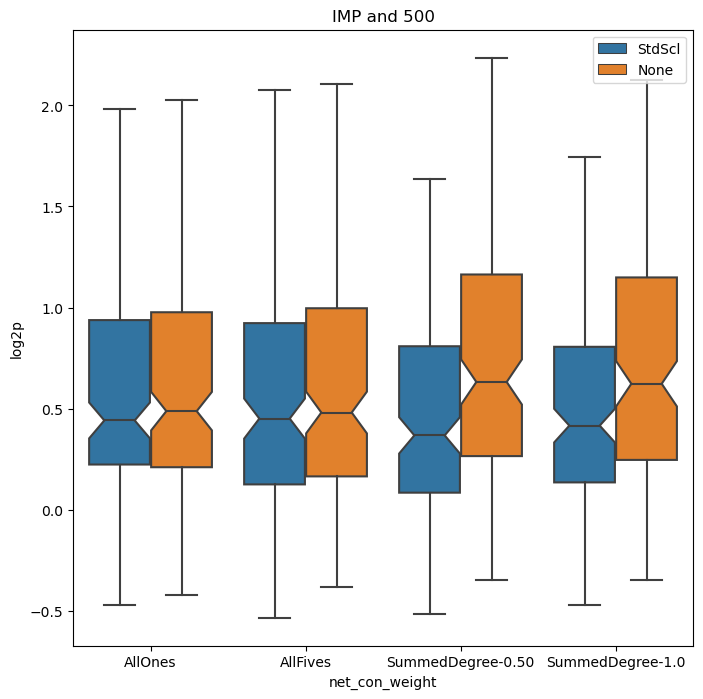

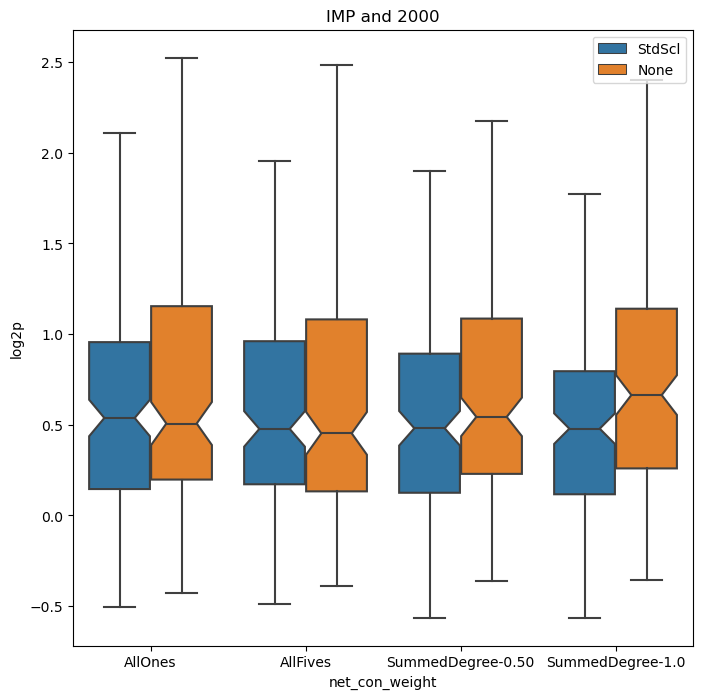

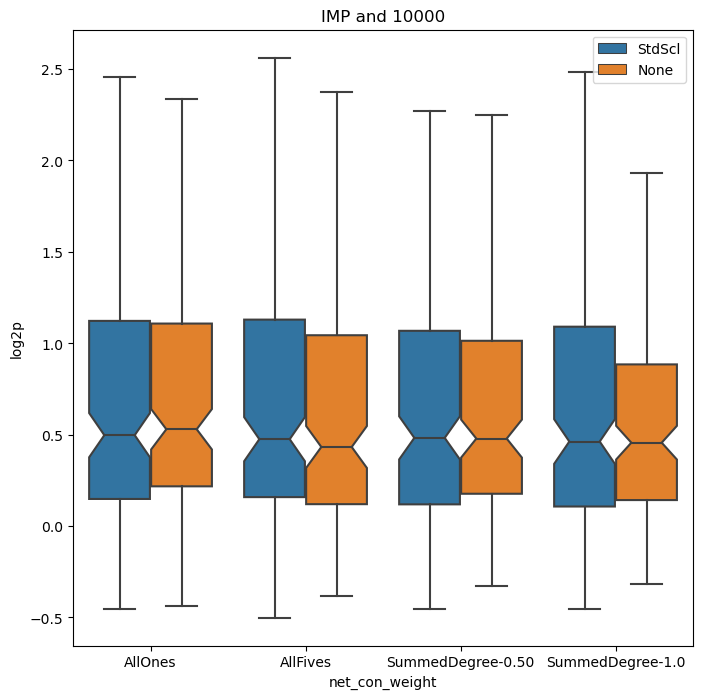

In [13]:
plot_hs_mm_SVD(df_final,'dim_size','net_con_weight','emb_params')

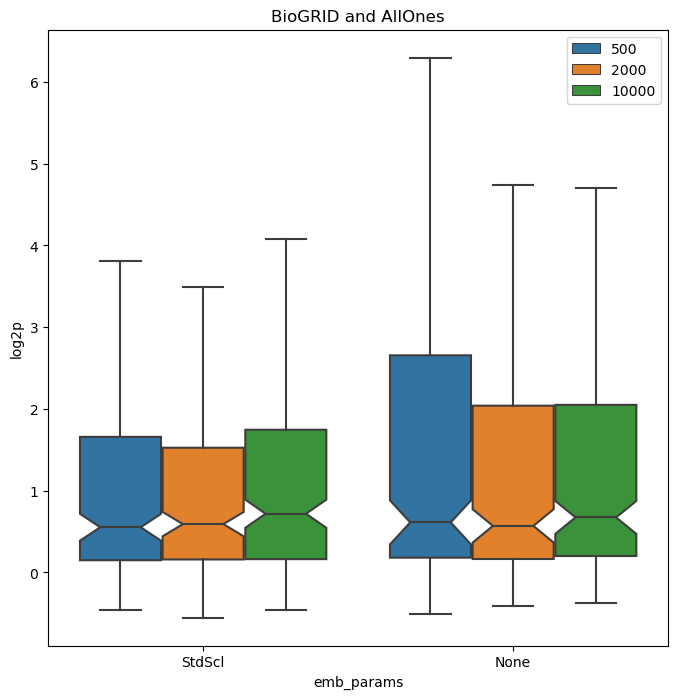

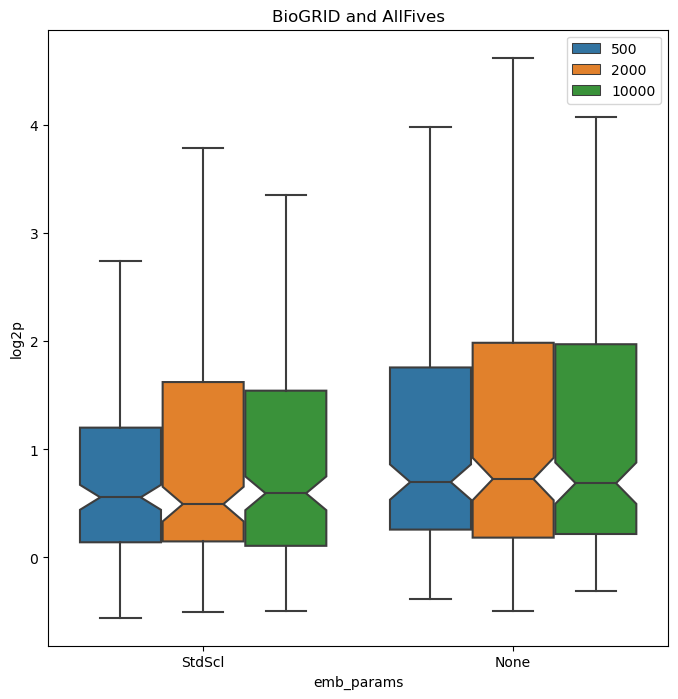

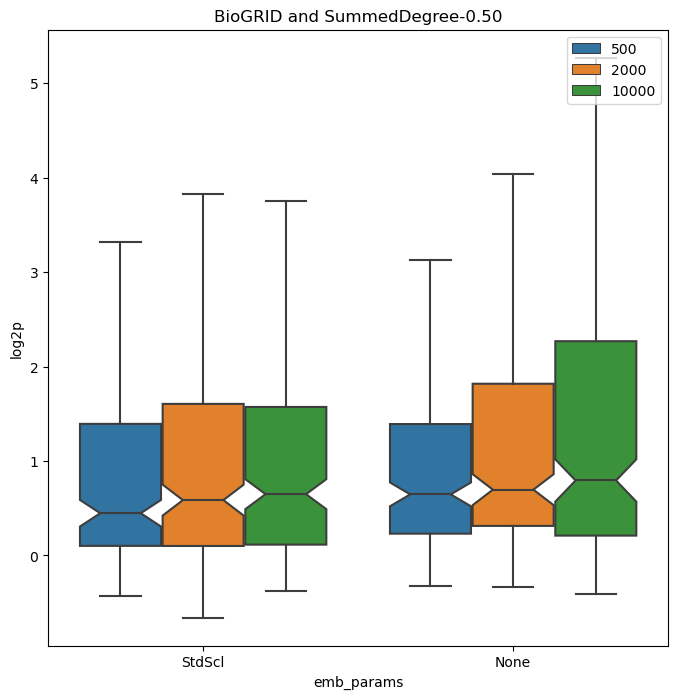

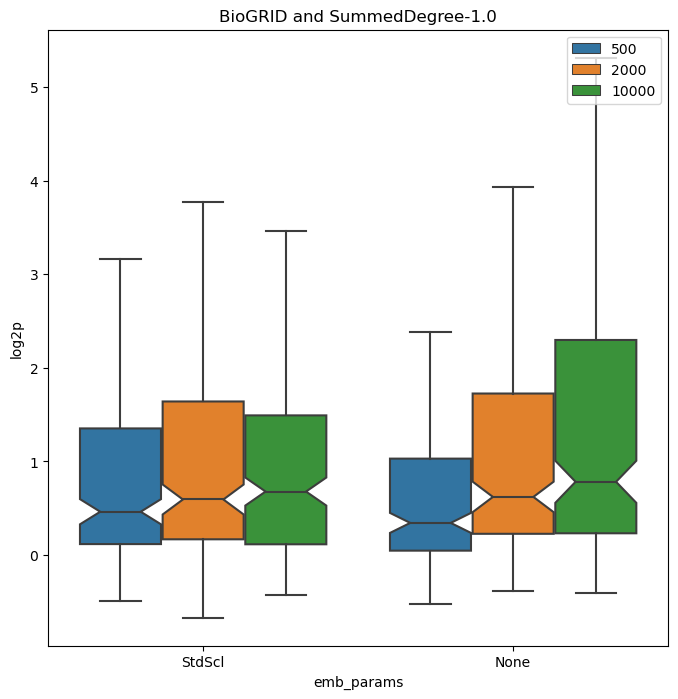

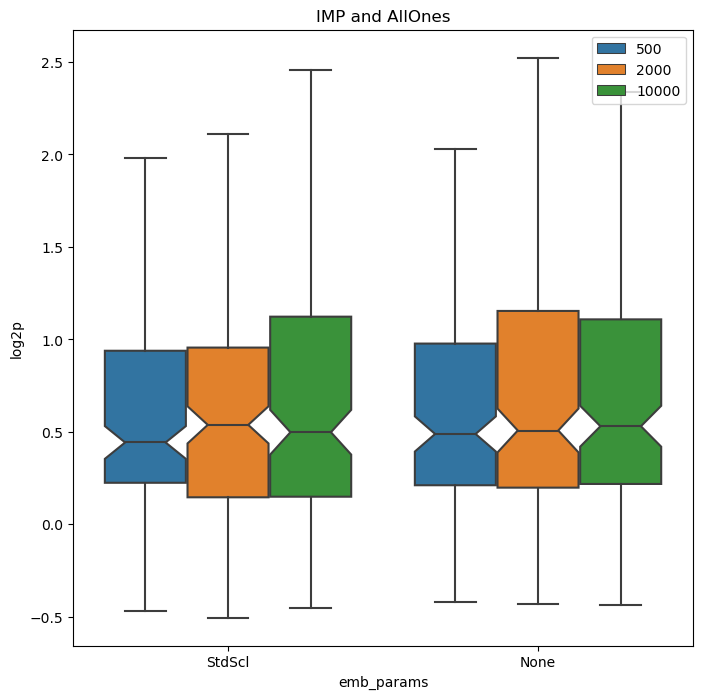

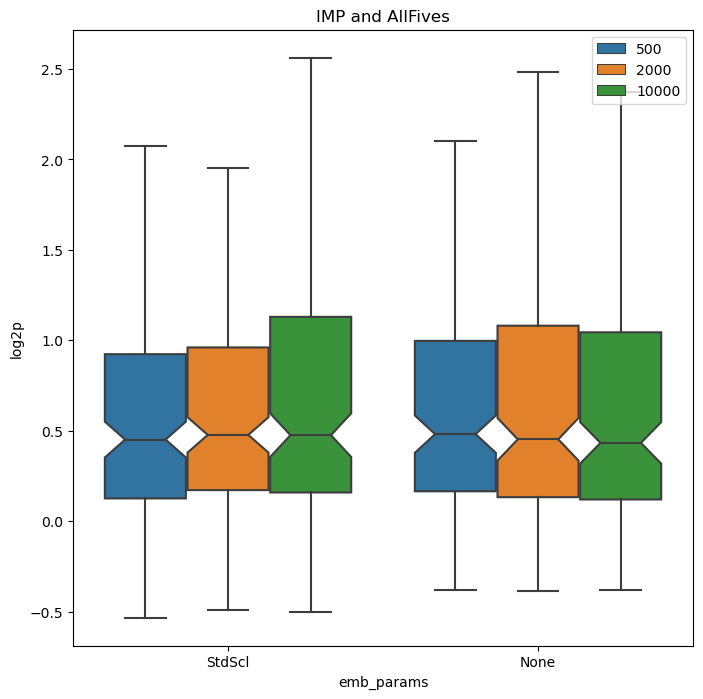

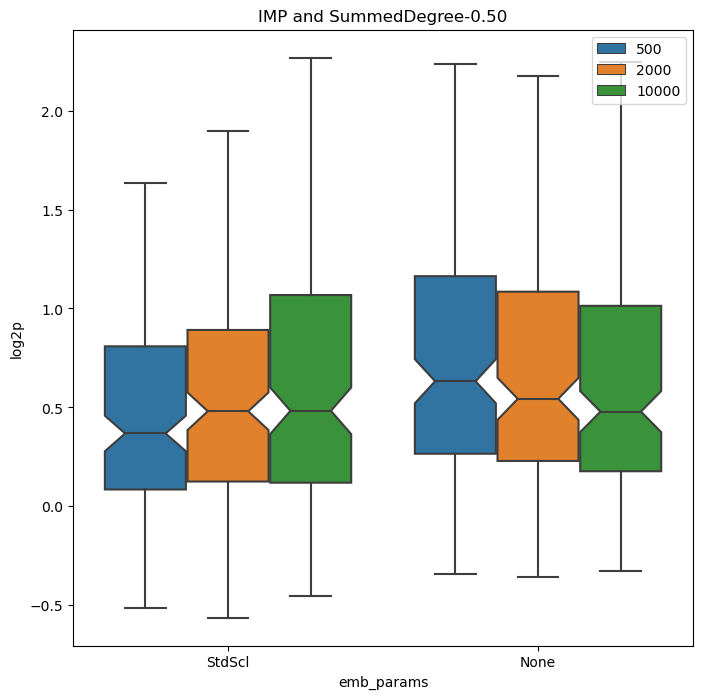

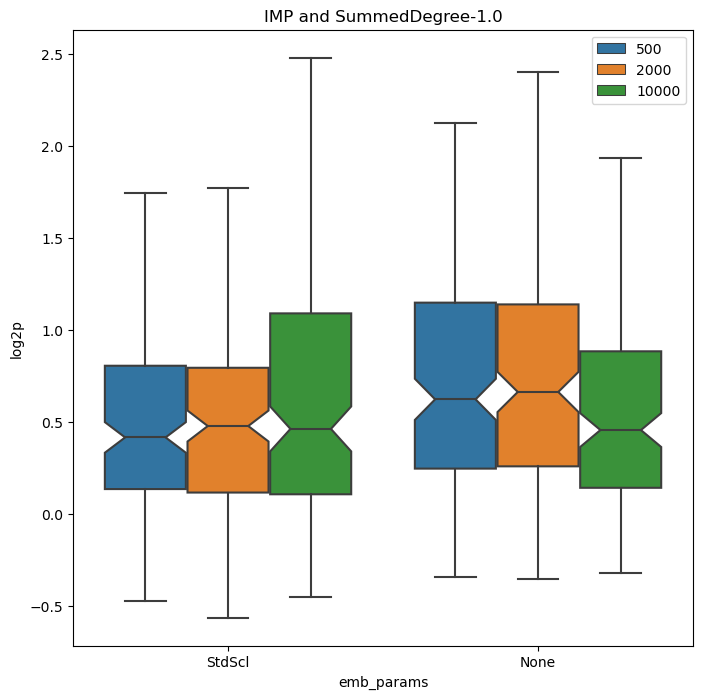

In [14]:
plot_hs_mm_SVD(df_final,'net_con_weight','emb_params','dim_size')

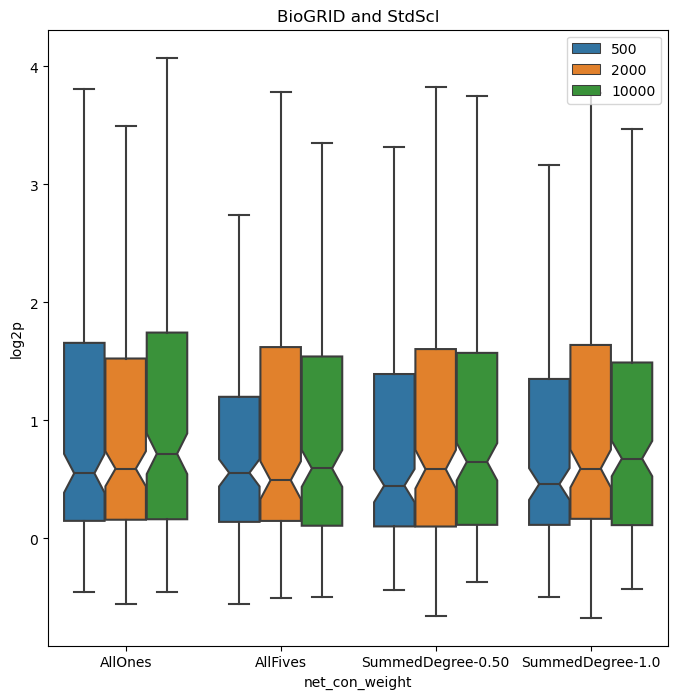

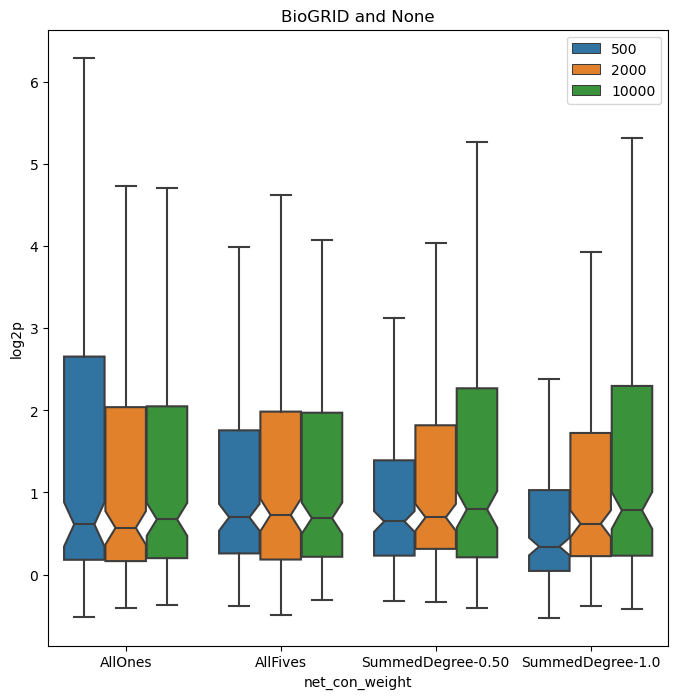

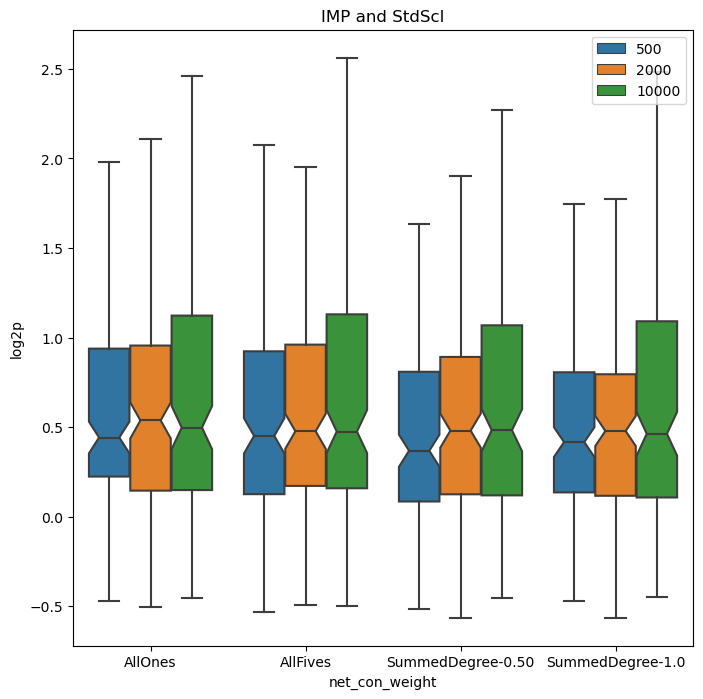

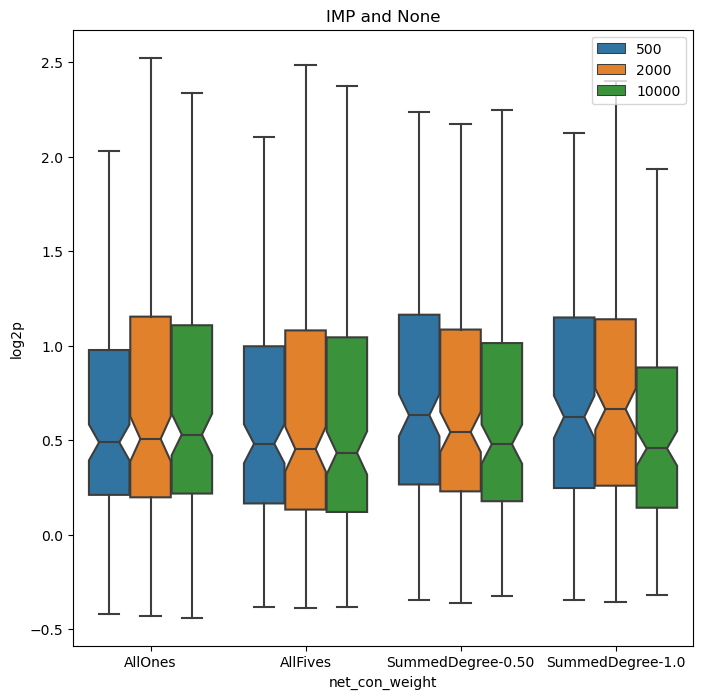

In [15]:
plot_hs_mm_SVD(df_final,'emb_params','net_con_weight','dim_size')

# Plots for hs(or mm)-adj-inf-0.8

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


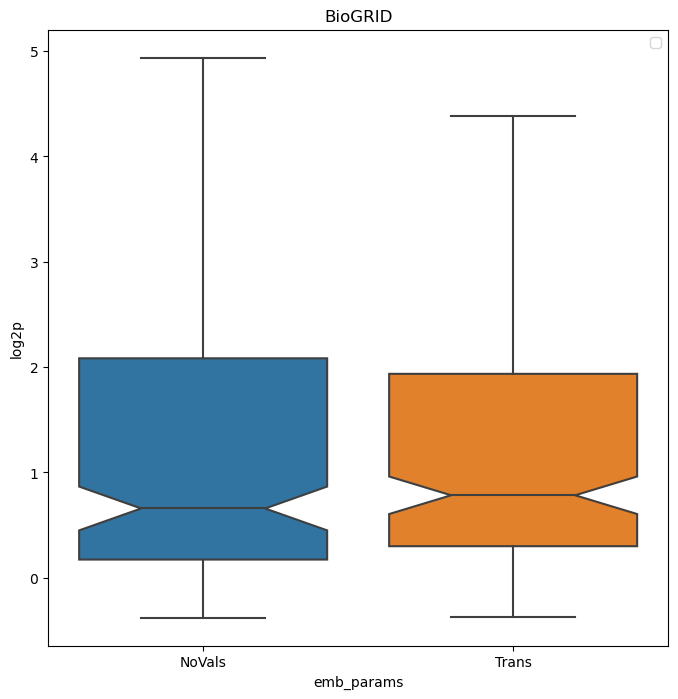

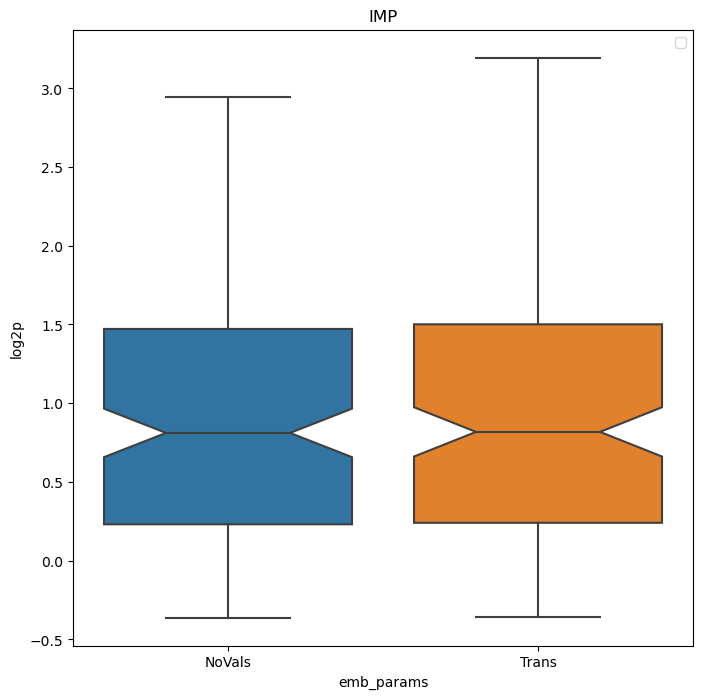

In [16]:
df_tmp = df_final[df_final['feature_type']=='%s-adj-inf-0.8'%specie_tmp]
for anet in ['BioGRID','IMP']:
    df_tmp2 = df_tmp[df_tmp['network']==anet]
    fig,ax = plt.subplots(figsize=(8,8))
    sns.boxplot(data=df_tmp2,x='emb_params',y='log2p',
                notch=True,showfliers=False)
    plt.legend(loc=1)
    ax.set_title(anet)

# plots for hs(or mm)-SVD

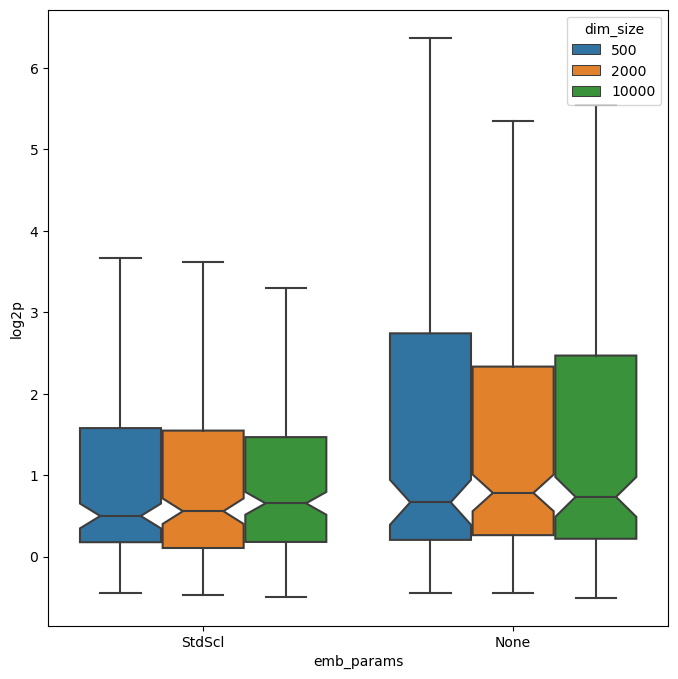

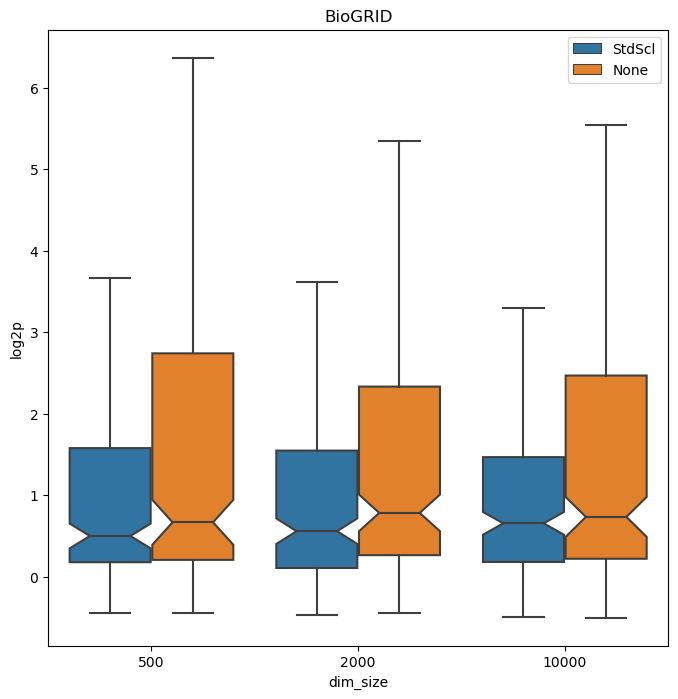

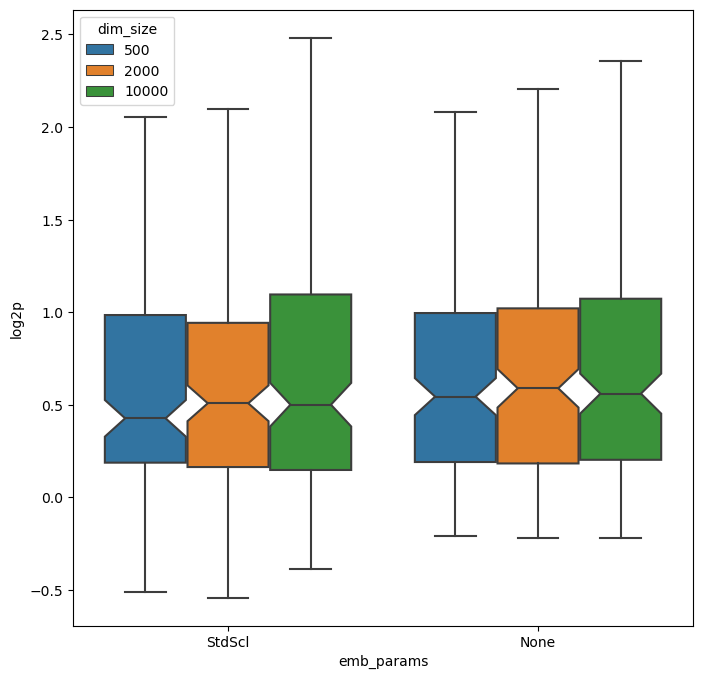

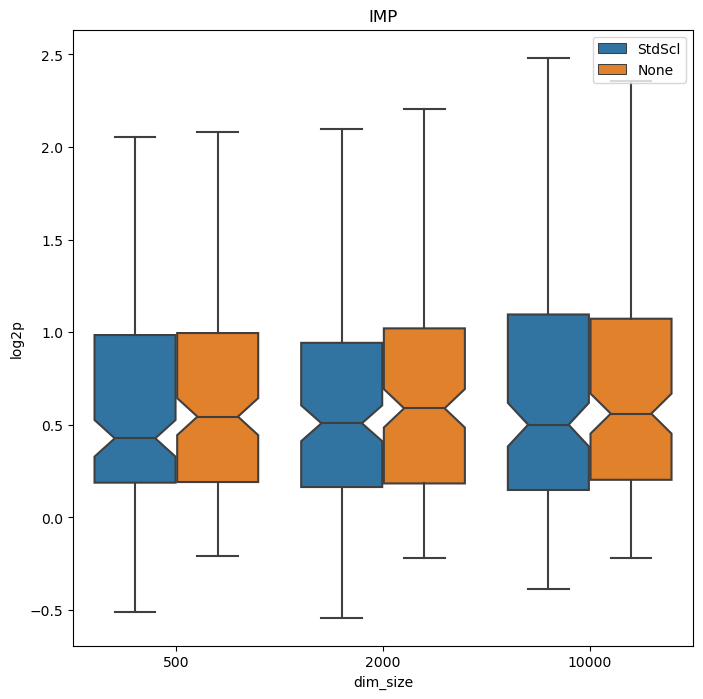

In [17]:
df_tmp = df_final[df_final['feature_type']=='%s-SVD-raw'%specie_tmp]
for anet in ['BioGRID','IMP']:
    df_tmp2 = df_tmp[df_tmp['network']==anet]
    fig,ax = plt.subplots(figsize=(8,8))
    sns.boxplot(data=df_tmp2,x='emb_params',y='log2p',hue='dim_size',
                notch=True,showfliers=False)
    fig,ax = plt.subplots(figsize=(8,8))
    sns.boxplot(data=df_tmp2,x='dim_size',y='log2p',hue='emb_params',
                notch=True,showfliers=False)
    plt.legend(loc=1)
    ax.set_title(anet)